<a href="https://colab.research.google.com/github/2yoojin/capstone/blob/main/AA_Decompose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.core.nanops import nanmean as pd_nanmean
from statsmodels.tsa.seasonal import DecomposeResult
# from statsmodels.tsa.filters._utils import _maybe_get_pandas_wrapper_freq
# from statsmodels.tsa.filters._utils import _get_pandas_wrapper
import statsmodels.api as sm
from matplotlib import rcParams
import warnings
warnings.filterwarnings(action='ignore')

from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/My Drive/HanRiver_dataset(2010~2023).csv')
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


fw    wl  wlobscd       ymdhm    observatory  interest  attention  \
0  6.08  1.78  1018655  2010010100  Daegok Bridge       3.8        5.5   
1  6.08  1.78  1018655  2010010101  Daegok Bridge       3.8        5.5   
2  6.08  1.78  1018655  2010010102  Daegok Bridge       3.8        5.5   
3  6.08  1.78  1018655  2010010103  Daegok Bridge       3.8        5.5   
4  6.08  1.78  1018655  2010010104  Daegok Bridge       3.8        5.5   

   caution  serious   latitude   longitude             datetime        date  \
0      7.0      8.5  37.468742  127.122572  2010-01-01 00:00:00  2010-01-01   
1      7.0      8.5  37.468742  127.122572  2010-01-01 01:00:00  2010-01-01   
2      7.0      8.5  37.468742  127.122572  2010-01-01 02:00:00  2010-01-01   
3      7.0      8.5  37.468742  127.122572  2010-01-01 03:00:00  2010-01-01   
4      7.0      8.5  37.468742  127.122572  2010-01-01 04:00:00  2010-01-01   

   year  month  day  hour   rf warning level  
0  2010      1    1     0  0.0        normal  
1  2010      1    1     1  0.0        normal  
2  2010      1    1     2  0.0        normal  
3  2010      1    1     3  0.0        normal  
4  2010      1    1     4  0.0        normal

In [70]:
def get_observatory(data, name):
  df = data[data['observatory'] ==  name]
  df.set_index('datetime', inplace=True)
  warning_level = data[['observatory', 'interest', 'attention', 'caution', 'serious']]
  warning_level = warning_level.drop_duplicates().reset_index(drop=True)
  warning_level = warning_level[warning_level['observatory'] == name]
  return df, warning_level

In [71]:
from functools import wraps
from statsmodels.tools.data import _is_using_pandas
from statsmodels.tsa.base import datetools
from statsmodels.tsa.tsatools import freq_to_period

# def _pandas_wrapper(X, trim_head=None, trim_tail=None, names=None):
#     index = X.index
#     #TODO: allow use index labels
#     if trim_head is None and trim_tail is None:
#         index = index
#     elif trim_tail is None:
#         index = index[trim_head:]
#     elif trim_head is None:
#         index = index[:-trim_tail]
#     else:
#         index = index[trim_head:-trim_tail]
#     if hasattr(X, "columns"):
#         if names is None:
#             names = X.columns
#         return X.__class__(X.values, index=index, columns=names)
#     else:
#         if names is None:
#             names = X.name
#         return X.__class__(X.values, index=index, name=names)

def anomaly_detection(point, warning_level):
    warning_levels = np.repeat(warning_level, len(point))
    anomalies = point > warning_level
    return anomalies

def AA_decompose(df, period=24, lo_frac=0.6, lo_delta=0.01, warning_level=None):
    lowess = sm.nonparametric.lowess
    # _pandas_wrapper = _get_pandas_wrapper(df)
    # _pandas_wrapper = df

    water_level = np.asanyarray(df['wl']).squeeze()

    anomalies = anomaly_detection(water_level, warning_level)
    # water_level = water_level[~anomalies]

    trend = lowess(water_level, [x for x in range(len(water_level))],
                   frac=lo_frac,
                   delta=lo_delta * len(water_level),
                   return_sorted=False)
    detrended = water_level / trend
    period = min(period, len(water_level))
    period_median = np.array([pd_nanmean(detrended[i::period])
                              for i in range(period)])

    seasonal = np.repeat(period_median, len(water_level) // period + 1)[:len(water_level)]
    # seasonal = np.tile(period_median, len(water_level) // period + 1)[:len(water_level)]

    # seasonal = np.zeros_like(water_level)
    # n = len(water_level)
    # for i in range(1, period+1):
    #   seasonal += np.sin(2 * np.pi * i * np.arange(n) / period)
    # seasonal /= period

    resid_inter = detrended / seasonal
    resid_inter[0] = 1
    resid = resid_inter.copy()

    # results = list(map(_pandas_wrapper, [seasonal, trend, resid, water_level]))

    fig, axes = plt.subplots(5, 1, sharex=True, figsize=(10,12))

    axes[0].plot(water_level)
    axes[0].set_ylabel('Water Level')
    axes[1].plot(trend)
    axes[1].set_ylabel('Trend')
    axes[2].plot(seasonal)
    axes[2].set_ylabel('Seasonal')

    axes[3].plot(resid)
    axes[3].set_ylabel('Residual')
    axes[3].set_xlabel('Time')

    axes[4].plot(anomalies, color='r')
    axes[4].set_ylabel('Anomalies')
    axes[4].set_xlabel('Time')

    plt.suptitle(df['observatory'].iloc[0])
    plt.tight_layout()
    plt.show()
    return trend, seasonal, anomalies, resid

plt.rc('font', family='serif')
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

params = {
    'axes.labelsize': 8,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'text.usetex': False,
    'figure.figsize': [4.5, 4.5]
}
rcParams.update(params)
#trend, seasonal, anomalies, resid  = AA_decompose(df_dec, period=4, warning_level=warning_level['interest'].iloc[0])

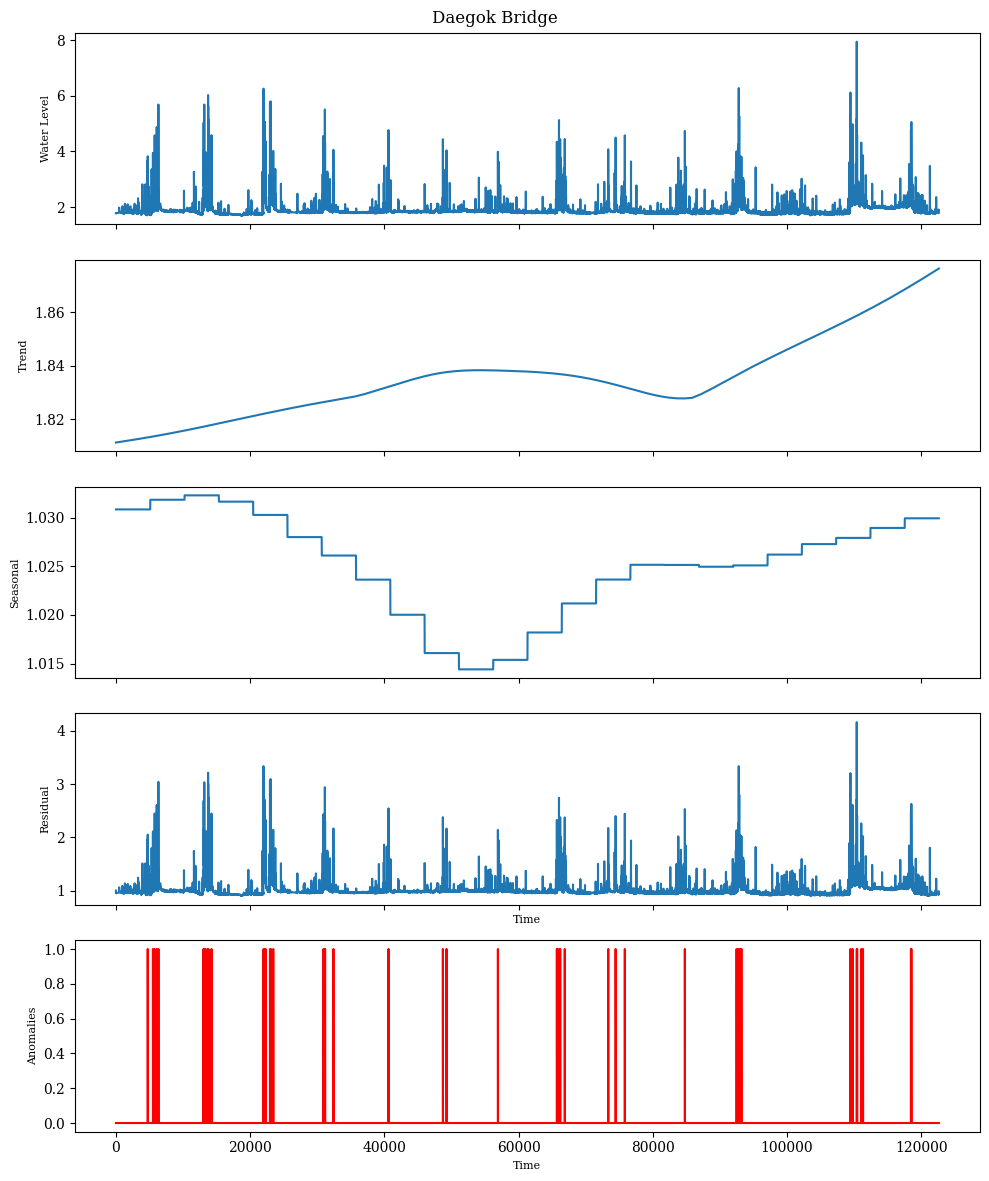

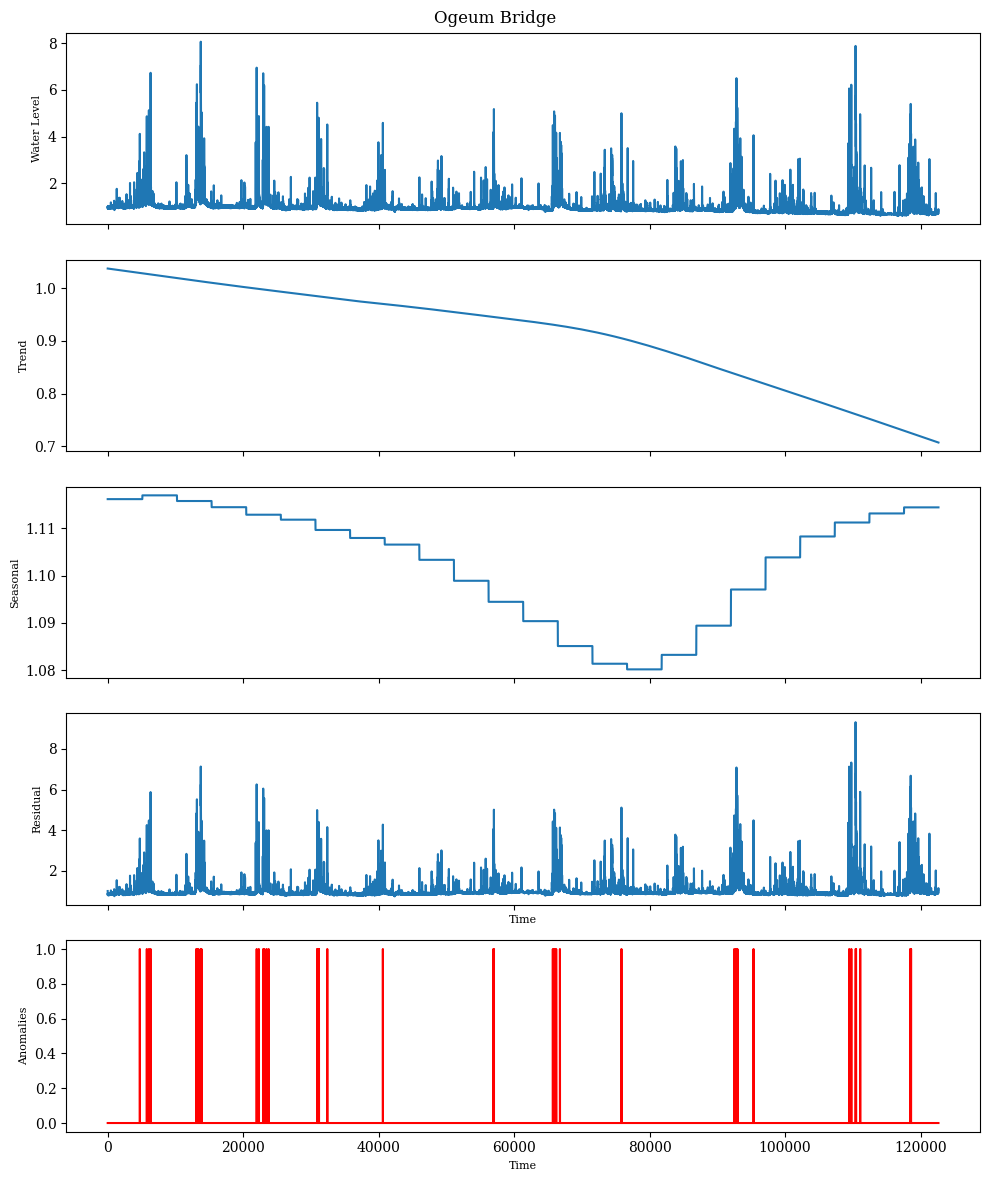

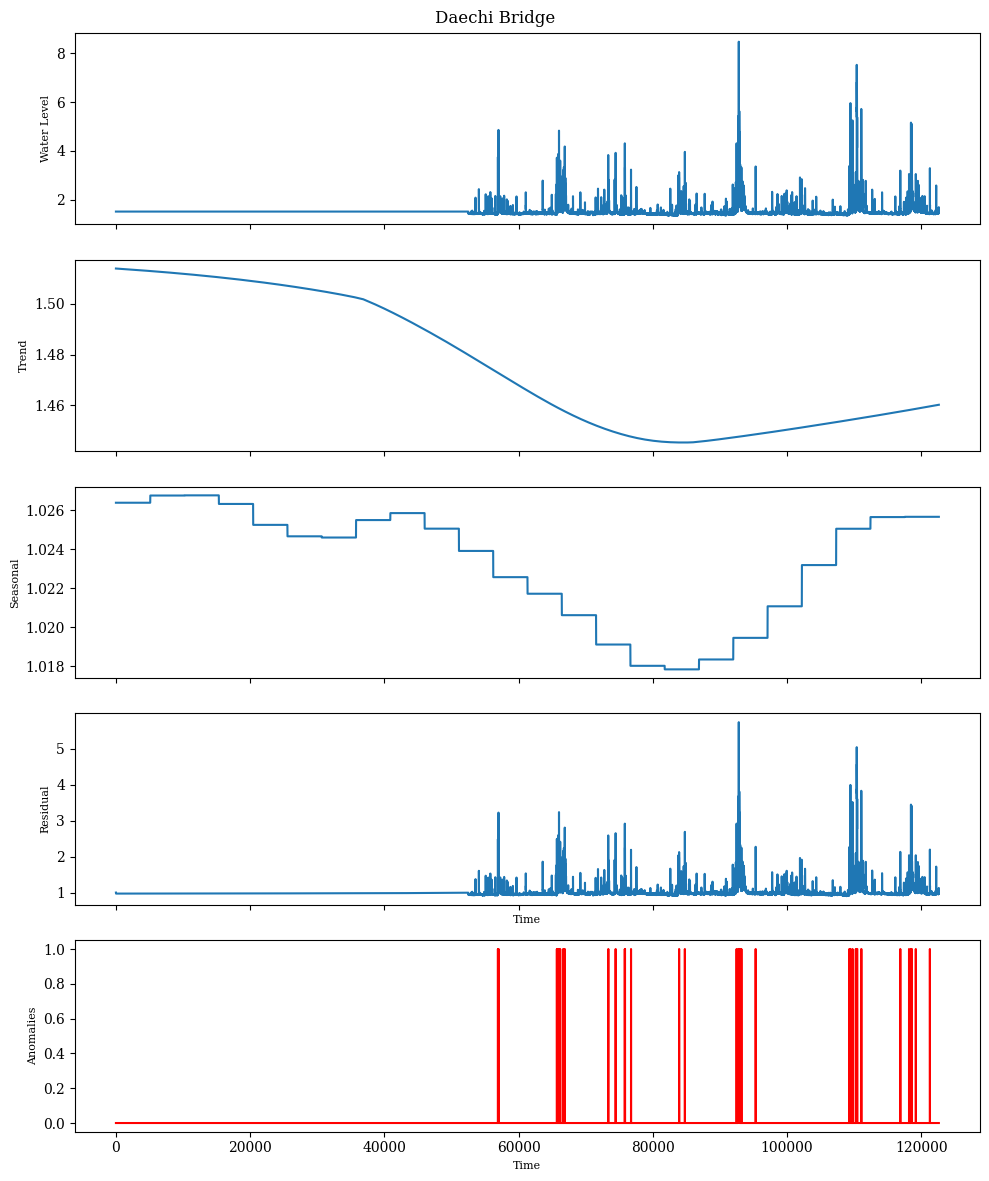

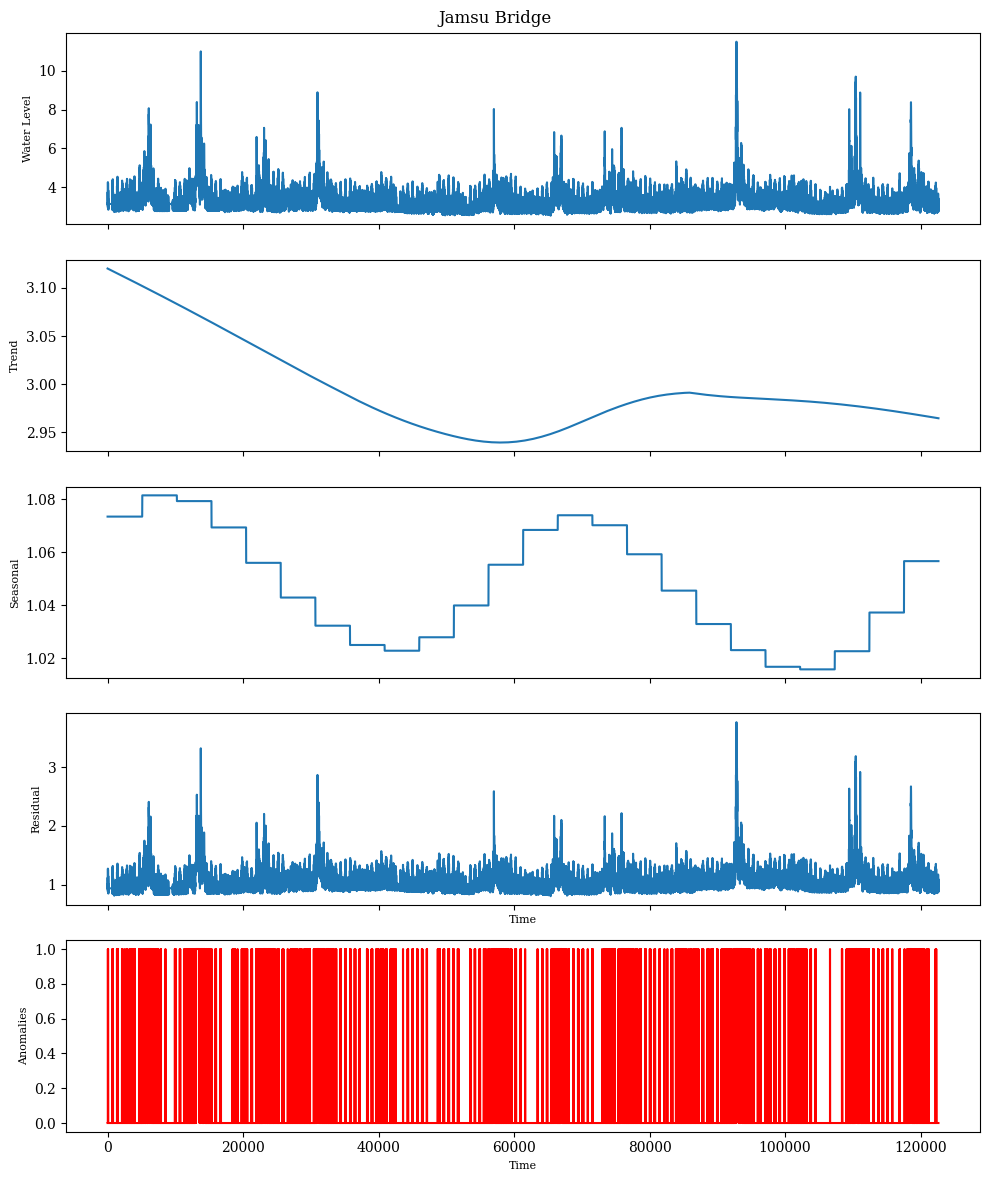

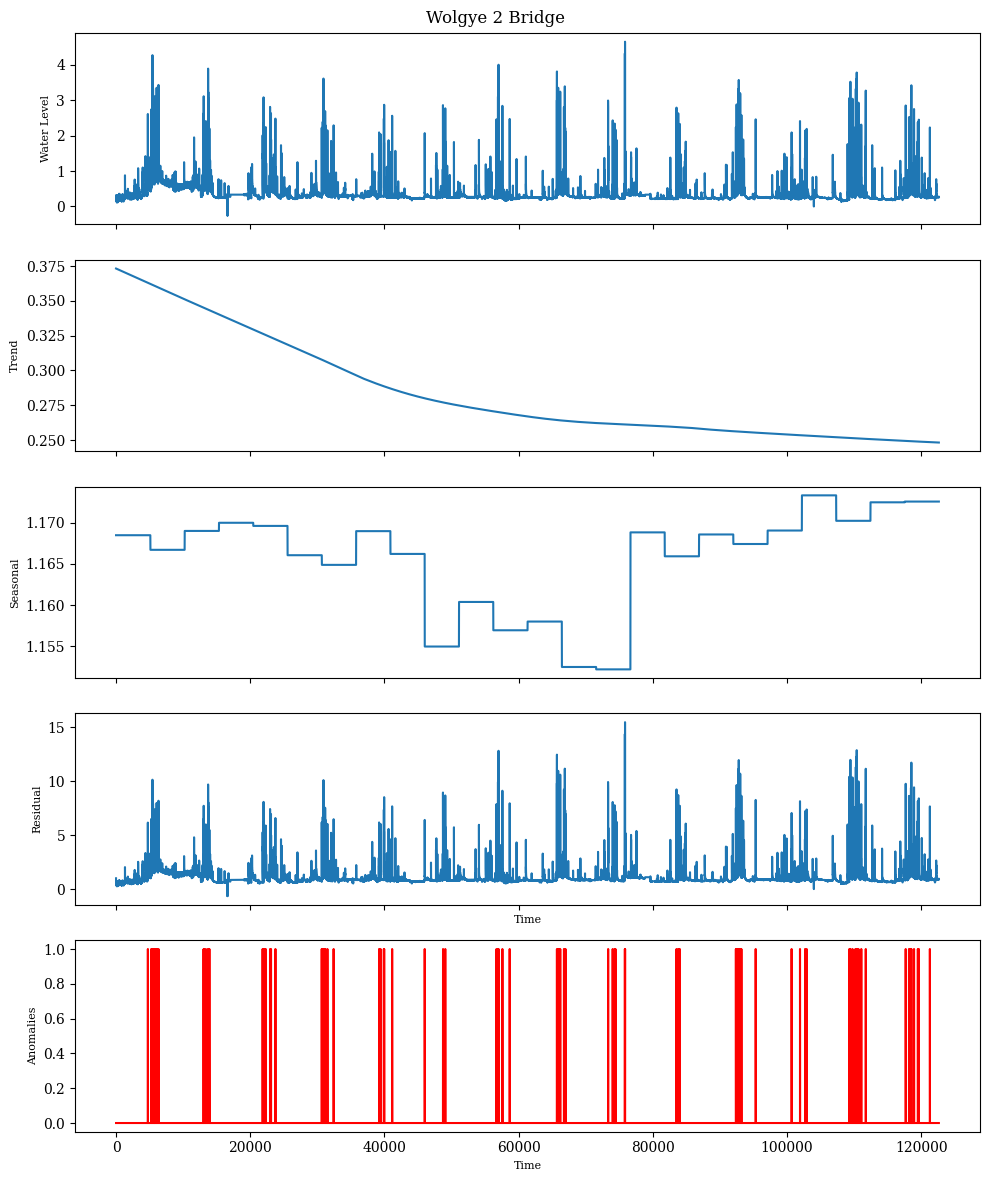

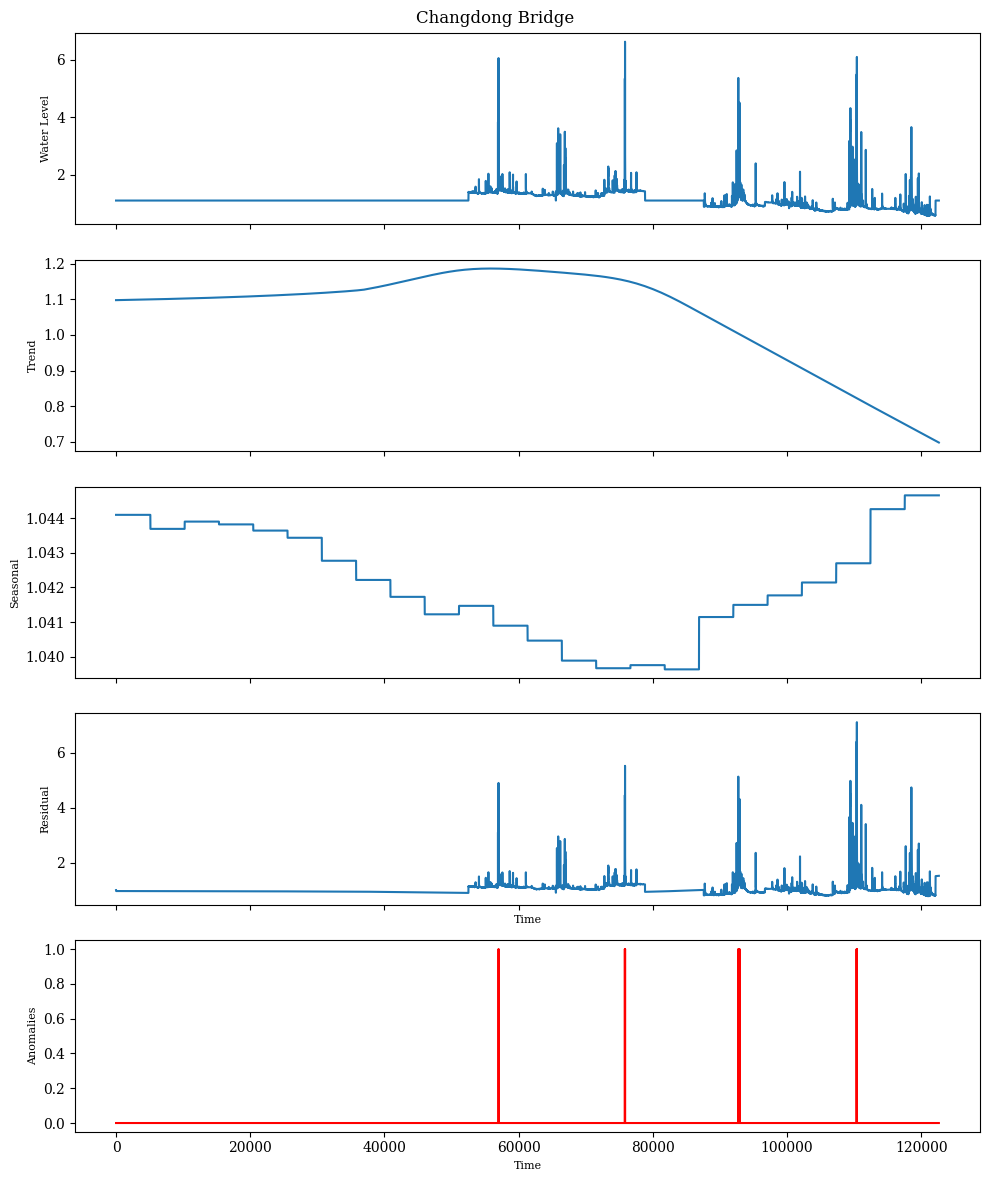

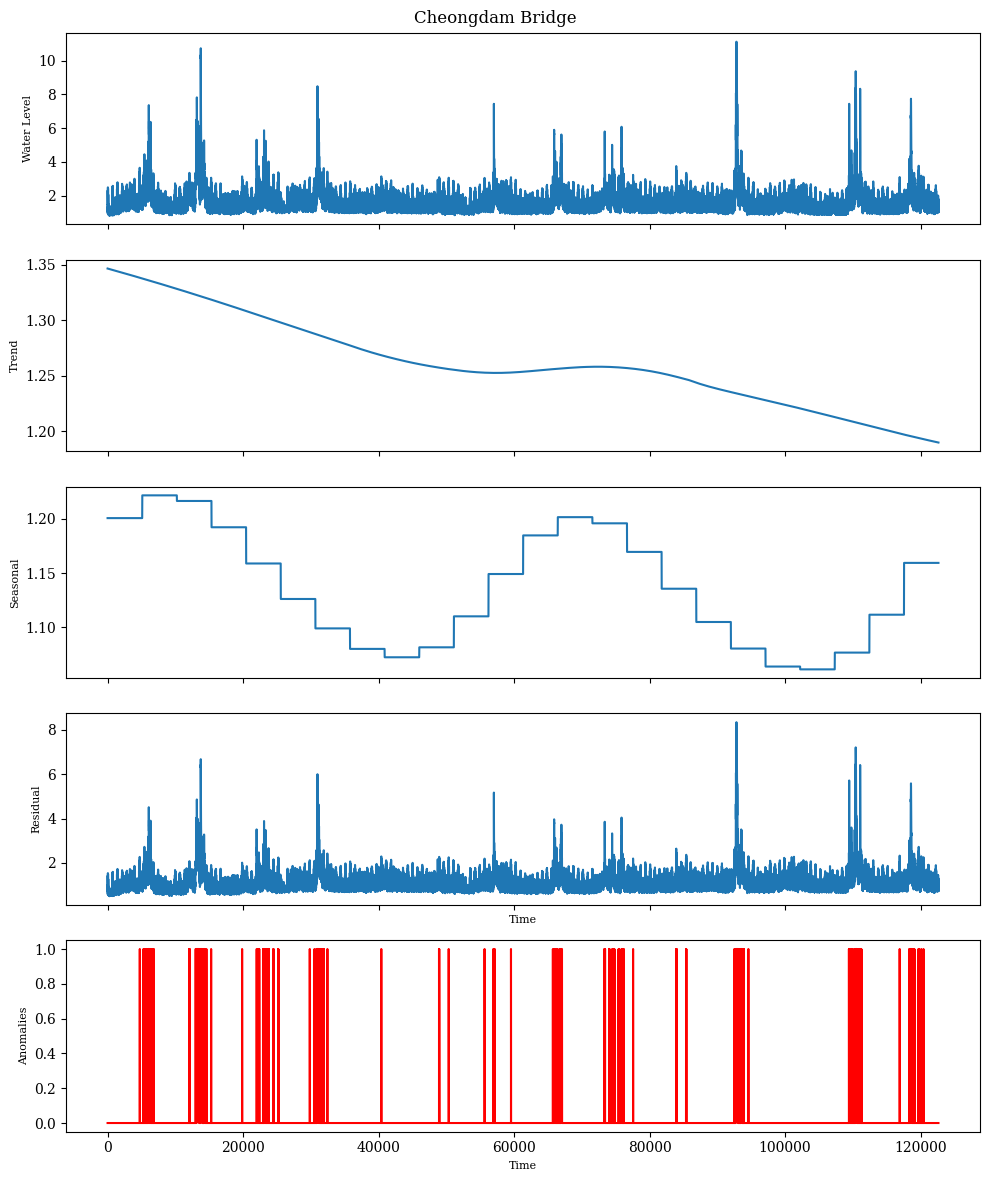

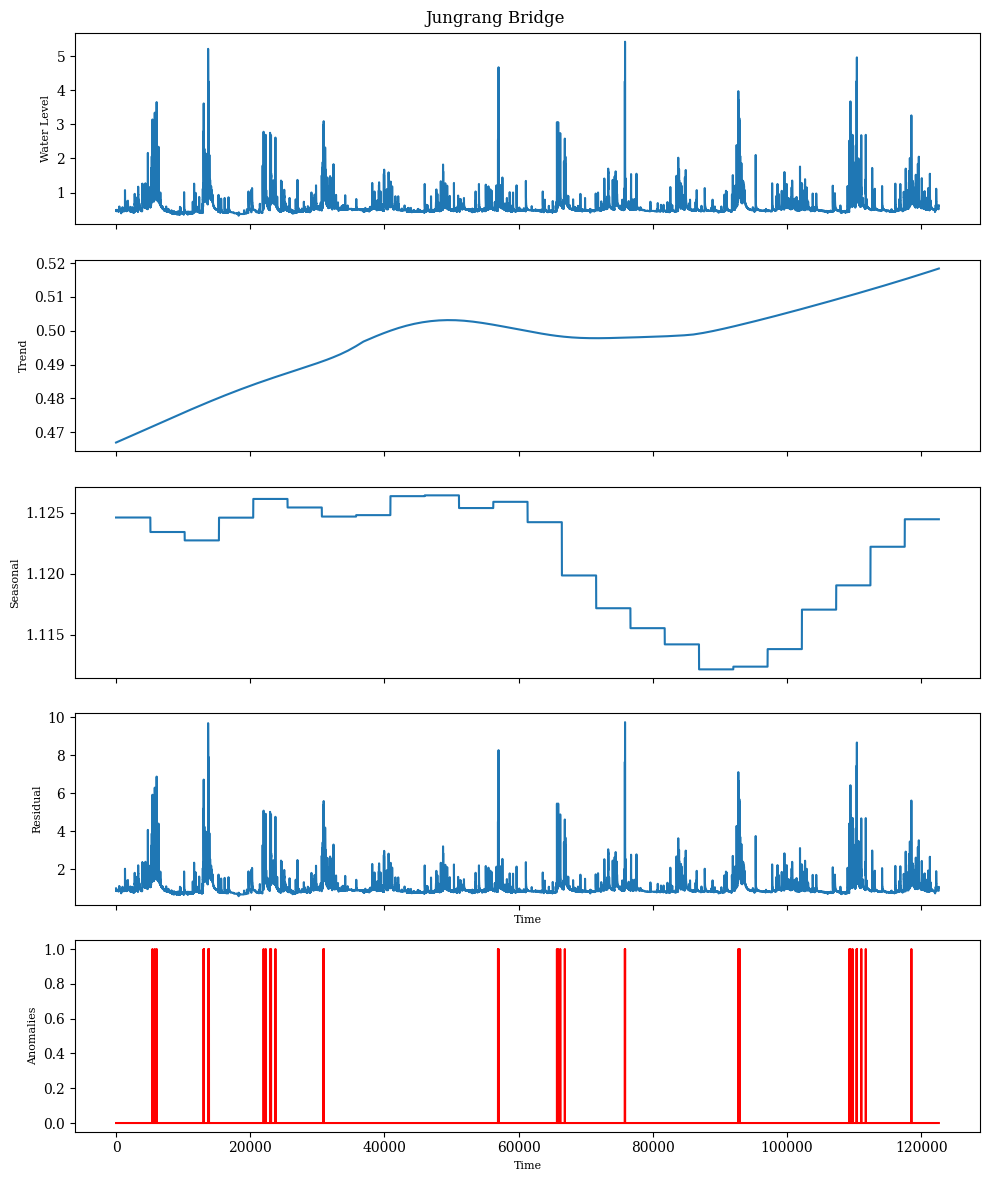

fw    wl  wlobscd       ymdhm      observatory  \
datetime                                                                  
2010-01-01 00:00:00    6.08  1.78  1018655  2010010100    Daegok Bridge   
2010-01-01 01:00:00    6.08  1.78  1018655  2010010101    Daegok Bridge   
2010-01-01 02:00:00    6.08  1.78  1018655  2010010102    Daegok Bridge   
2010-01-01 03:00:00    6.08  1.78  1018655  2010010103    Daegok Bridge   
2010-01-01 04:00:00    6.08  1.78  1018655  2010010104    Daegok Bridge   
...                     ...   ...      ...         ...              ...   
2023-12-31 19:00:00  128.90  1.13  1018640  2023123119  Gwangjin Bridge   
2023-12-31 20:00:00  124.87  1.13  1018640  2023123120  Gwangjin Bridge   
2023-12-31 21:00:00  124.87  1.13  1018640  2023123121  Gwangjin Bridge   
2023-12-31 22:00:00  128.90  1.13  1018640  2023123122  Gwangjin Bridge   
2023-12-31 23:00:00  124.87  1.13  1018640  2023123123  Gwangjin Bridge   

                     interest  attention  caution  serious   latitude  ...  \
datetime                                                               ...   
2010-01-01 00:00:00       3.8        5.5      7.0      8.5  37.468742  ...   
2010-01-01 01:00:00       3.8        5.5      7.0      8.5  37.468742  ...   
2010-01-01 02:00:00       3.8        5.5      7.0      8.5  37.468742  ...   
2010-01-01 03:00:00       3.8        5.5      7.0      8.5  37.468742  ...   
2010-01-01 04:00:00       3.8        5.5      7.0      8.5  37.468742  ...   
...                       ...        ...      ...      ...        ...  ...   
2023-12-31 19:00:00       3.0        8.0     10.5     13.6  37.542950  ...   
2023-12-31 20:00:00       3.0        8.0     10.5     13.6  37.542950  ...   
2023-12-31 21:00:00       3.0        8.0     10.5     13.6  37.542950  ...   
2023-12-31 22:00:00       3.0        8.0     10.5     13.6  37.542950  ...   
2023-12-31 23:00:00       3.0        8.0     10.5     13.6  37.542950  ...   

                     year month  day  hour   rf  warning level     trend  \
datetime                                                                   
2010-01-01 00:00:00  2010     1    1     0  0.0         normal  1.811253   
2010-01-01 01:00:00  2010     1    1     1  0.0         normal  1.811253   
2010-01-01 02:00:00  2010     1    1     2  0.0         normal  1.811253   
2010-01-01 03:00:00  2010     1    1     3  0.0         normal  1.811254   
2010-01-01 04:00:00  2010     1    1     4  0.0         normal  1.811254   
...                   ...   ...  ...   ...  ...            ...       ...   
2023-12-31 19:00:00  2023    12   31    19  4.7         normal  1.122638   
2023-12-31 20:00:00  2023    12   31    20  4.7         normal  1.122639   
2023-12-31 21:00:00  2023    12   31    21  4.7         normal  1.122640   
2023-12-31 22:00:00  2023    12   31    22  4.7         normal  1.122641   
2023-12-31 23:00:00  2023    12   31    23  4.7         normal  1.122642   

                     seasonal  anomalies  residual  
datetime                                            
2010-01-01 00:00:00  1.030851      False  1.000000  
2010-01-01 01:00:00  1.030851      False  0.953334  
2010-01-01 02:00:00  1.030851      False  0.953334  
2010-01-01 03:00:00  1.030851      False  0.953334  
2010-01-01 04:00:00  1.030851      False  0.953334  
...                       ...        ...       ...  
2023-12-31 19:00:00  1.052078      False  0.956733  
2023-12-31 20:00:00  1.052078      False  0.956732  
2023-12-31 21:00:00  1.052078      False  0.956731  
2023-12-31 22:00:00  1.052078      False  0.956731  
2023-12-31 23:00:00  1.052078      False  0.956730  

[1471716 rows x 22 columns]

In [72]:
df_list = []

for bridge in data['observatory'].unique():
  df_dec, warning_level = get_observatory(data, bridge)
  trend, seasonal, anomalies, resid = AA_decompose(df_dec, period=24, warning_level = warning_level['interest'].iloc[0])
  df_dec['trend'] = trend
  df_dec['seasonal'] = seasonal
  df_dec['anomalies'] = anomalies
  df_dec['residual'] = resid
  df_list.append(df_dec)

decompose_by_interest = pd.concat(df_list)
decompose_by_interest

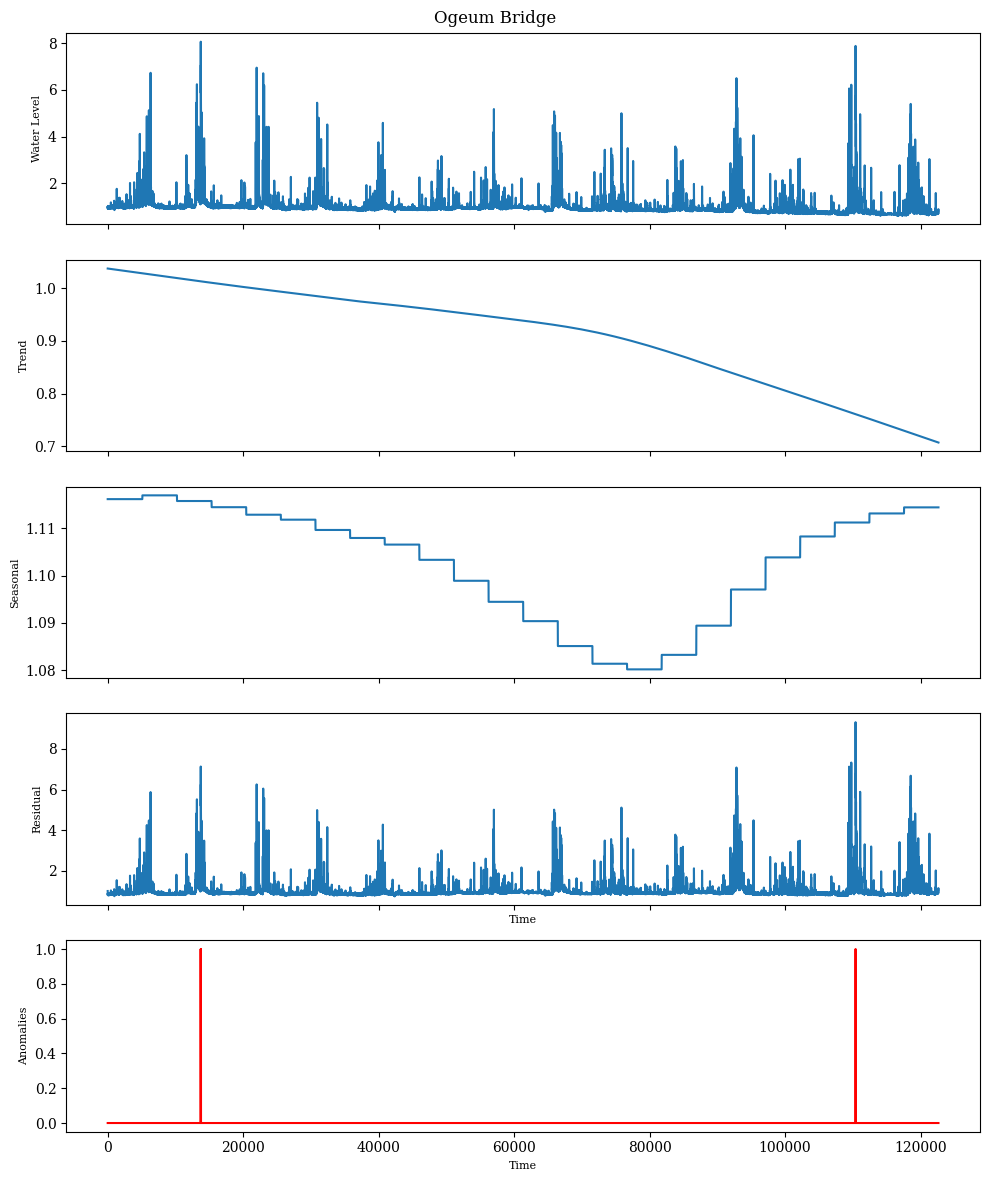

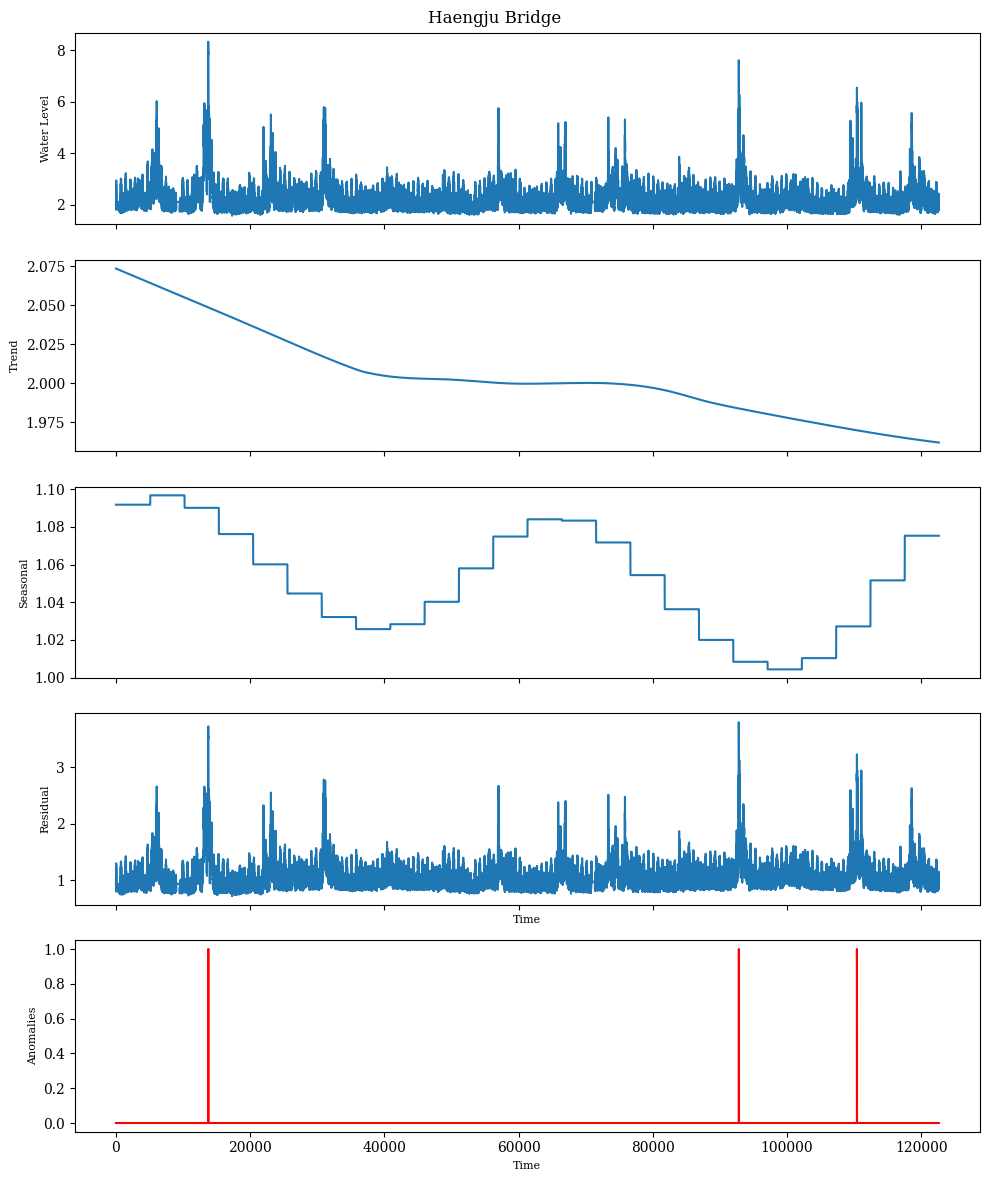

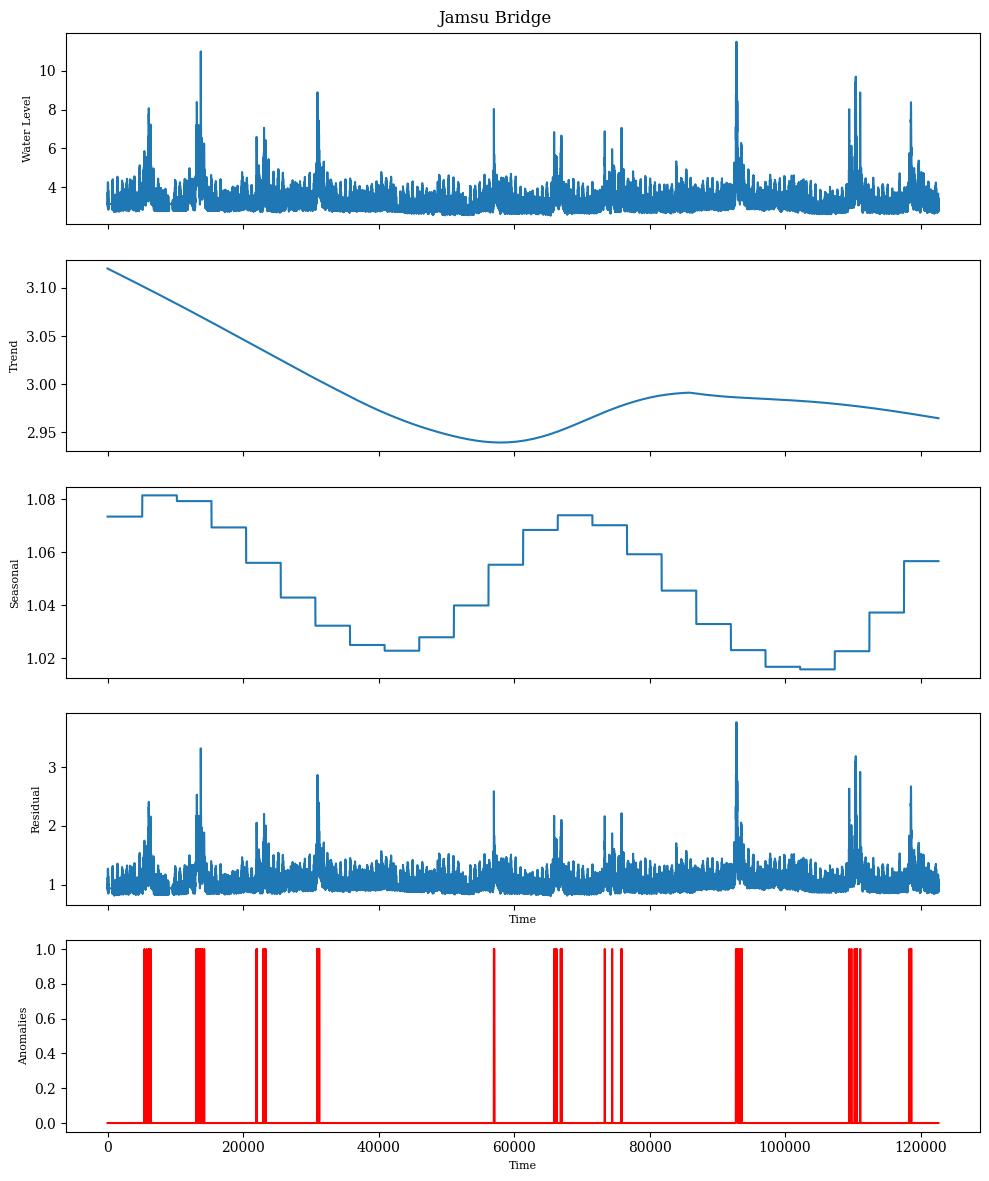

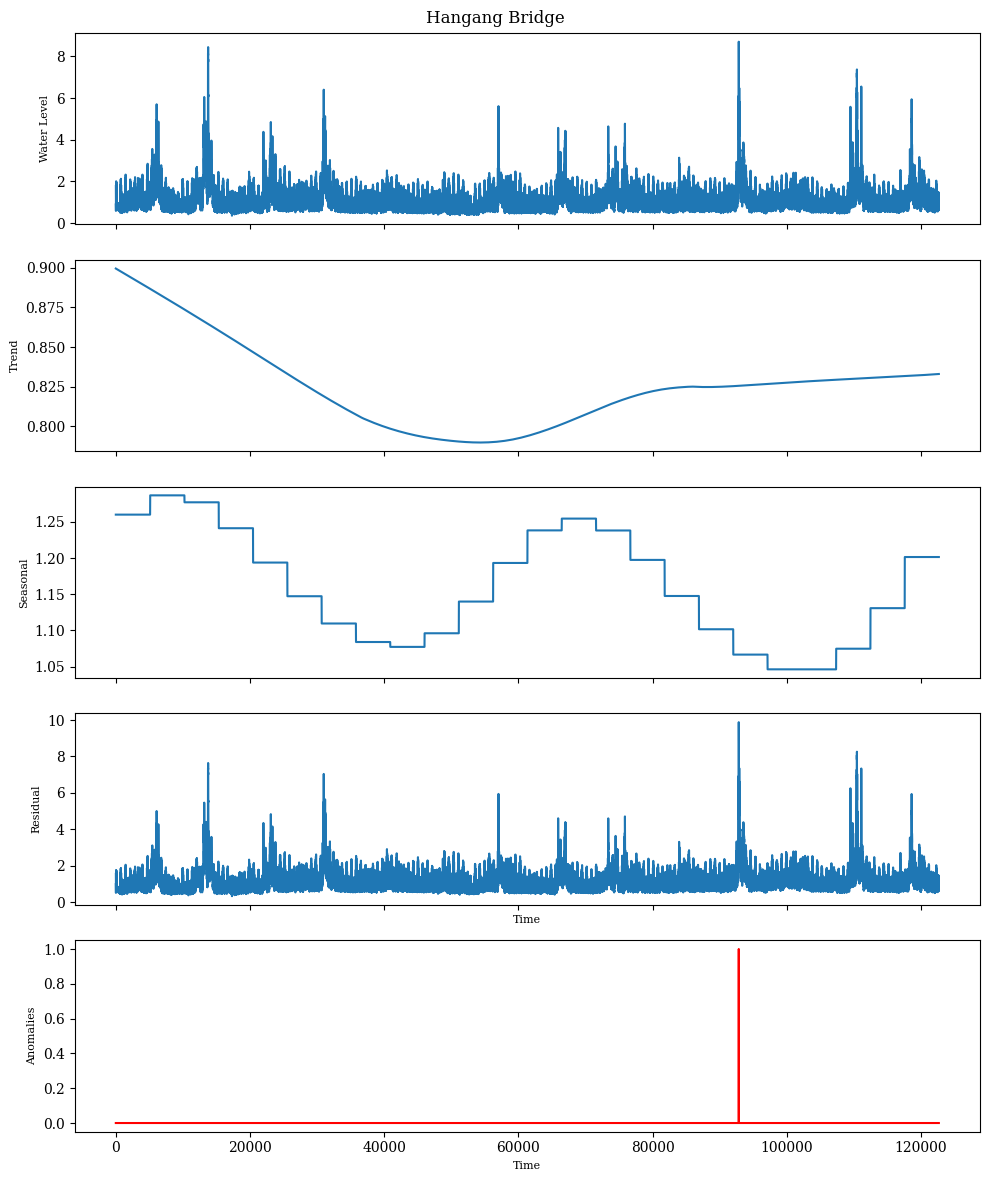

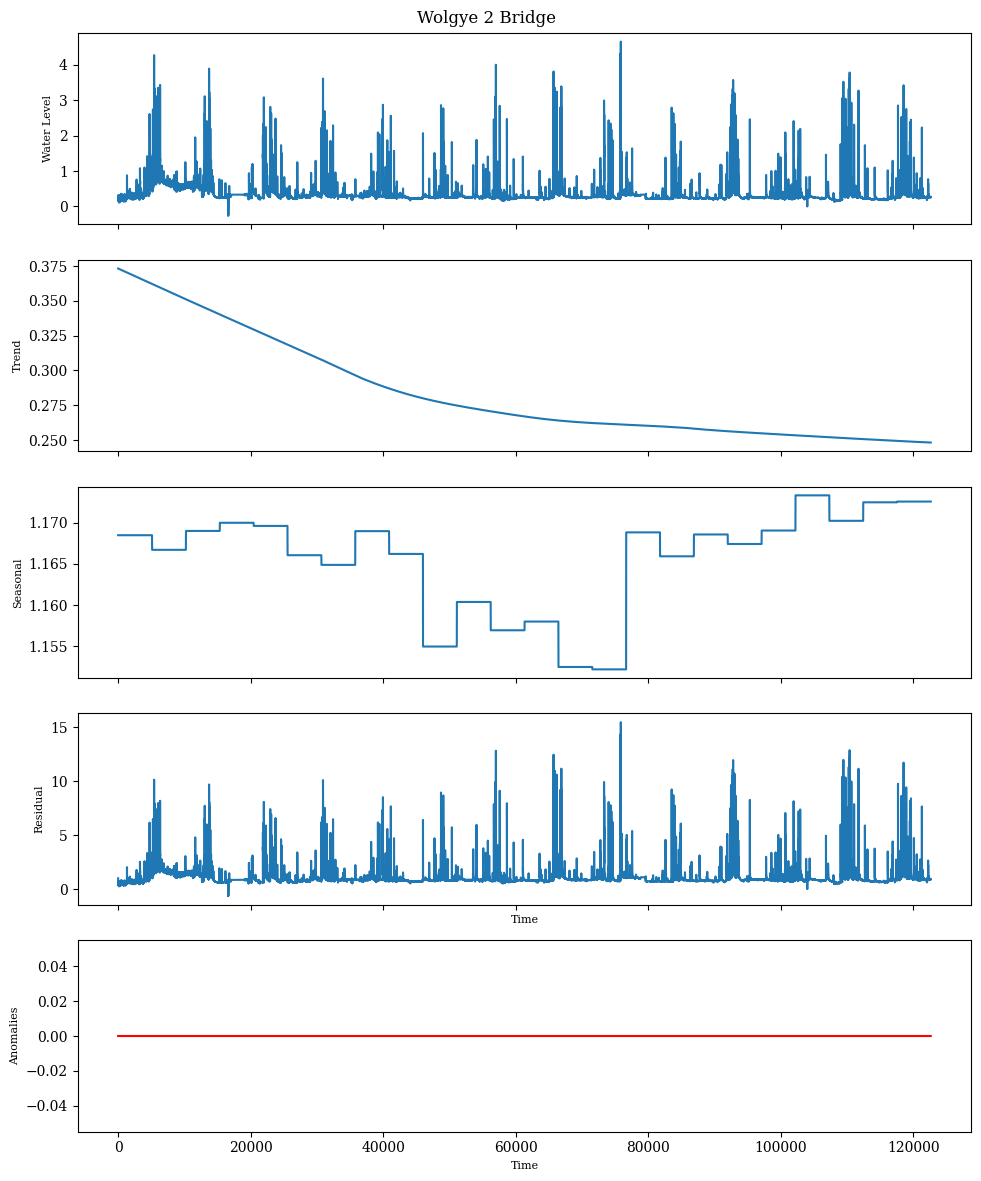

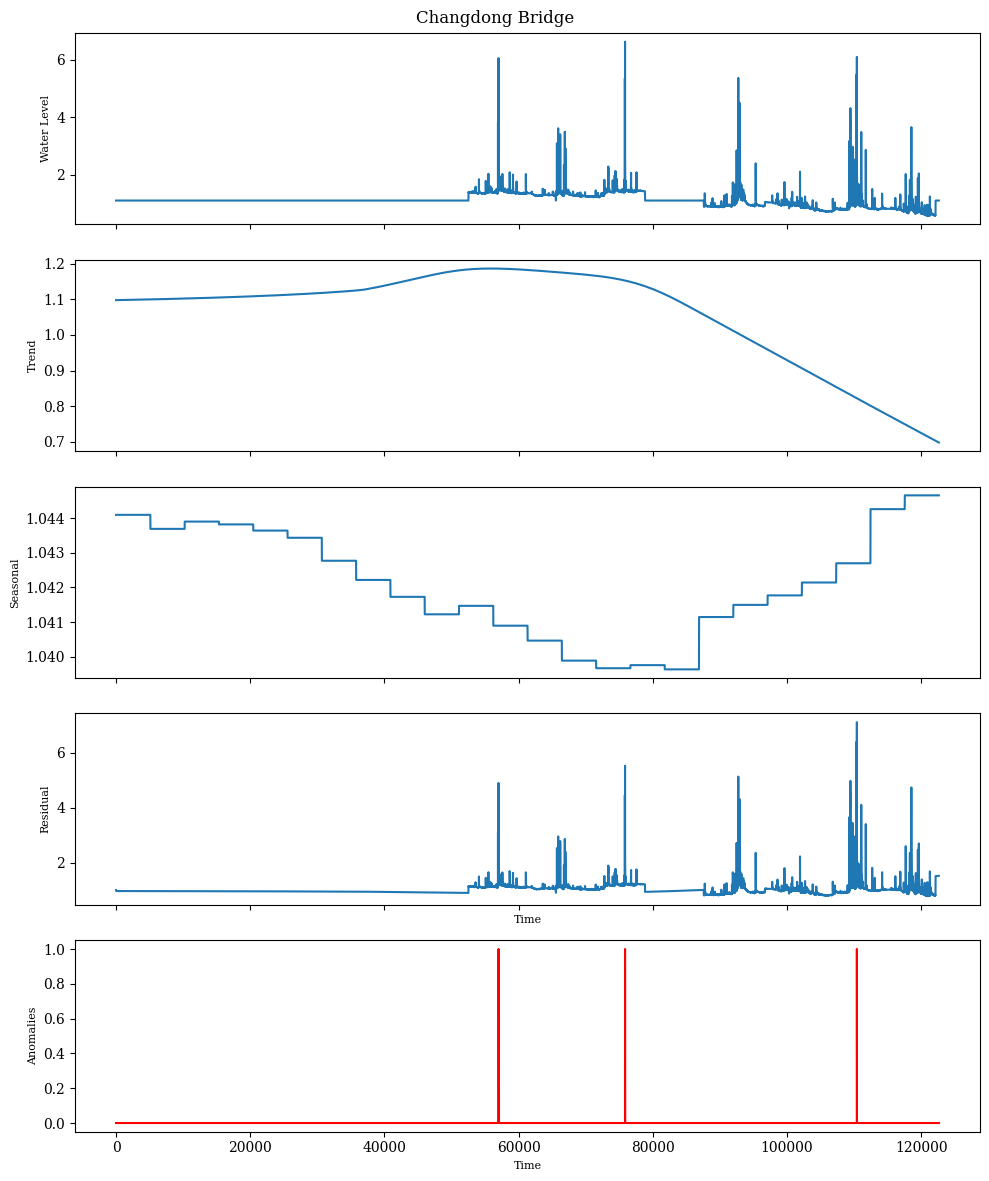

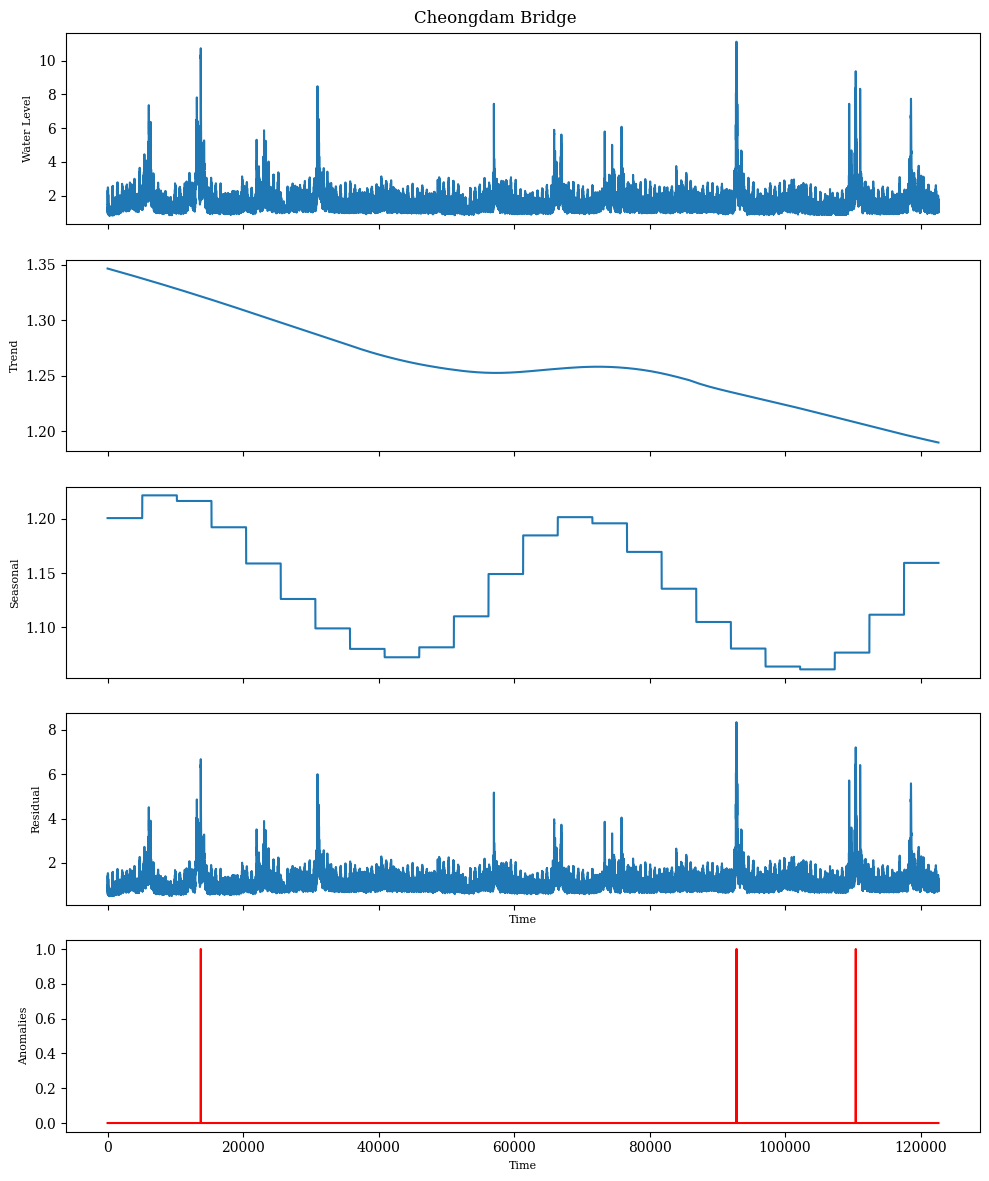

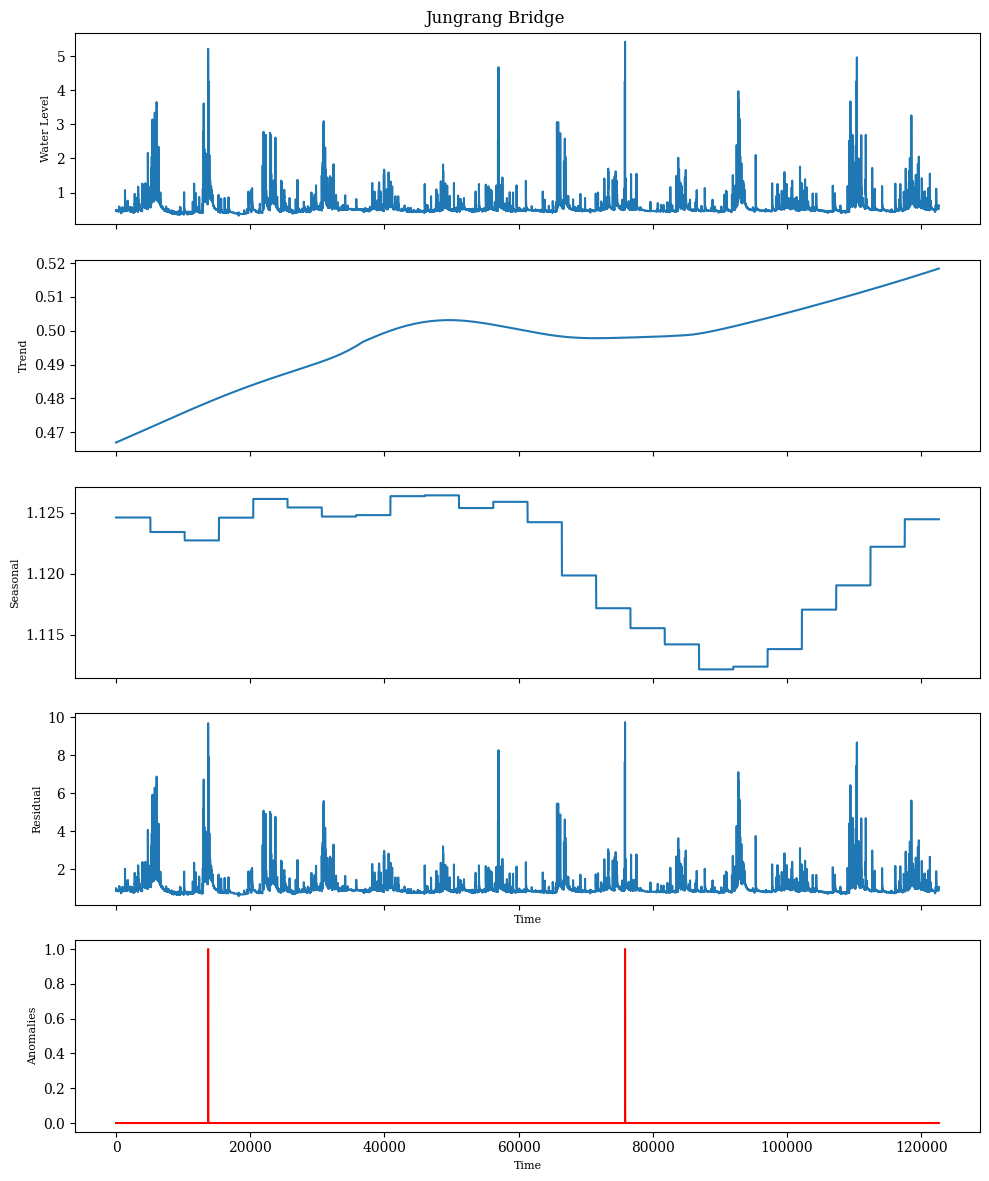

fw    wl  wlobscd       ymdhm      observatory  \
datetime                                                                  
2010-01-01 00:00:00    6.08  1.78  1018655  2010010100    Daegok Bridge   
2010-01-01 01:00:00    6.08  1.78  1018655  2010010101    Daegok Bridge   
2010-01-01 02:00:00    6.08  1.78  1018655  2010010102    Daegok Bridge   
2010-01-01 03:00:00    6.08  1.78  1018655  2010010103    Daegok Bridge   
2010-01-01 04:00:00    6.08  1.78  1018655  2010010104    Daegok Bridge   
...                     ...   ...      ...         ...              ...   
2023-12-31 19:00:00  128.90  1.13  1018640  2023123119  Gwangjin Bridge   
2023-12-31 20:00:00  124.87  1.13  1018640  2023123120  Gwangjin Bridge   
2023-12-31 21:00:00  124.87  1.13  1018640  2023123121  Gwangjin Bridge   
2023-12-31 22:00:00  128.90  1.13  1018640  2023123122  Gwangjin Bridge   
2023-12-31 23:00:00  124.87  1.13  1018640  2023123123  Gwangjin Bridge   

                     interest  attention  caution  serious   latitude  ...  \
datetime                                                               ...   
2010-01-01 00:00:00       3.8        5.5      7.0      8.5  37.468742  ...   
2010-01-01 01:00:00       3.8        5.5      7.0      8.5  37.468742  ...   
2010-01-01 02:00:00       3.8        5.5      7.0      8.5  37.468742  ...   
2010-01-01 03:00:00       3.8        5.5      7.0      8.5  37.468742  ...   
2010-01-01 04:00:00       3.8        5.5      7.0      8.5  37.468742  ...   
...                       ...        ...      ...      ...        ...  ...   
2023-12-31 19:00:00       3.0        8.0     10.5     13.6  37.542950  ...   
2023-12-31 20:00:00       3.0        8.0     10.5     13.6  37.542950  ...   
2023-12-31 21:00:00       3.0        8.0     10.5     13.6  37.542950  ...   
2023-12-31 22:00:00       3.0        8.0     10.5     13.6  37.542950  ...   
2023-12-31 23:00:00       3.0        8.0     10.5     13.6  37.542950  ...   

                     year month  day  hour   rf  warning level     trend  \
datetime                                                                   
2010-01-01 00:00:00  2010     1    1     0  0.0         normal  1.811253   
2010-01-01 01:00:00  2010     1    1     1  0.0         normal  1.811253   
2010-01-01 02:00:00  2010     1    1     2  0.0         normal  1.811253   
2010-01-01 03:00:00  2010     1    1     3  0.0         normal  1.811254   
2010-01-01 04:00:00  2010     1    1     4  0.0         normal  1.811254   
...                   ...   ...  ...   ...  ...            ...       ...   
2023-12-31 19:00:00  2023    12   31    19  4.7         normal  1.122638   
2023-12-31 20:00:00  2023    12   31    20  4.7         normal  1.122639   
2023-12-31 21:00:00  2023    12   31    21  4.7         normal  1.122640   
2023-12-31 22:00:00  2023    12   31    22  4.7         normal  1.122641   
2023-12-31 23:00:00  2023    12   31    23  4.7         normal  1.122642   

                     seasonal  anomalies  residual  
datetime                                            
2010-01-01 00:00:00  1.030851      False  1.000000  
2010-01-01 01:00:00  1.030851      False  0.953334  
2010-01-01 02:00:00  1.030851      False  0.953334  
2010-01-01 03:00:00  1.030851      False  0.953334  
2010-01-01 04:00:00  1.030851      False  0.953334  
...                       ...        ...       ...  
2023-12-31 19:00:00  1.052078      False  0.956733  
2023-12-31 20:00:00  1.052078      False  0.956732  
2023-12-31 21:00:00  1.052078      False  0.956731  
2023-12-31 22:00:00  1.052078      False  0.956731  
2023-12-31 23:00:00  1.052078      False  0.956730  

[1471716 rows x 22 columns]

In [73]:
df_list = []

for bridge in data['observatory'].unique():
  df_dec, warning_level = get_observatory(data, bridge)
  trend, seasonal, anomalies, resid = AA_decompose(df_dec, period=24, warning_level = warning_level['attention'].iloc[0])
  df_dec['trend'] = trend
  df_dec['seasonal'] = seasonal
  df_dec['anomalies'] = anomalies
  df_dec['residual'] = resid
  df_list.append(df_dec)
decompose_by_attention = pd.concat(df_list)
decompose_by_attention

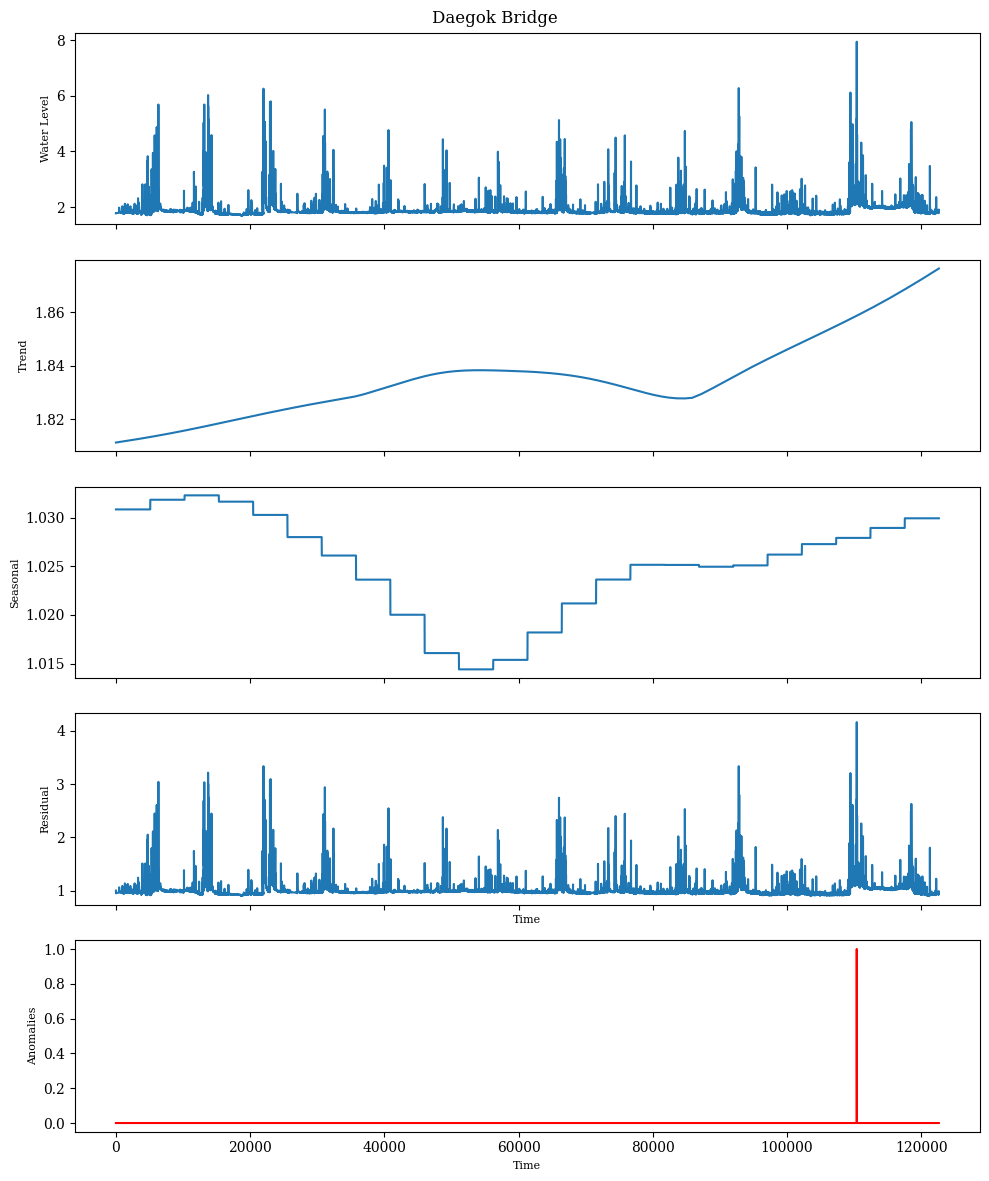

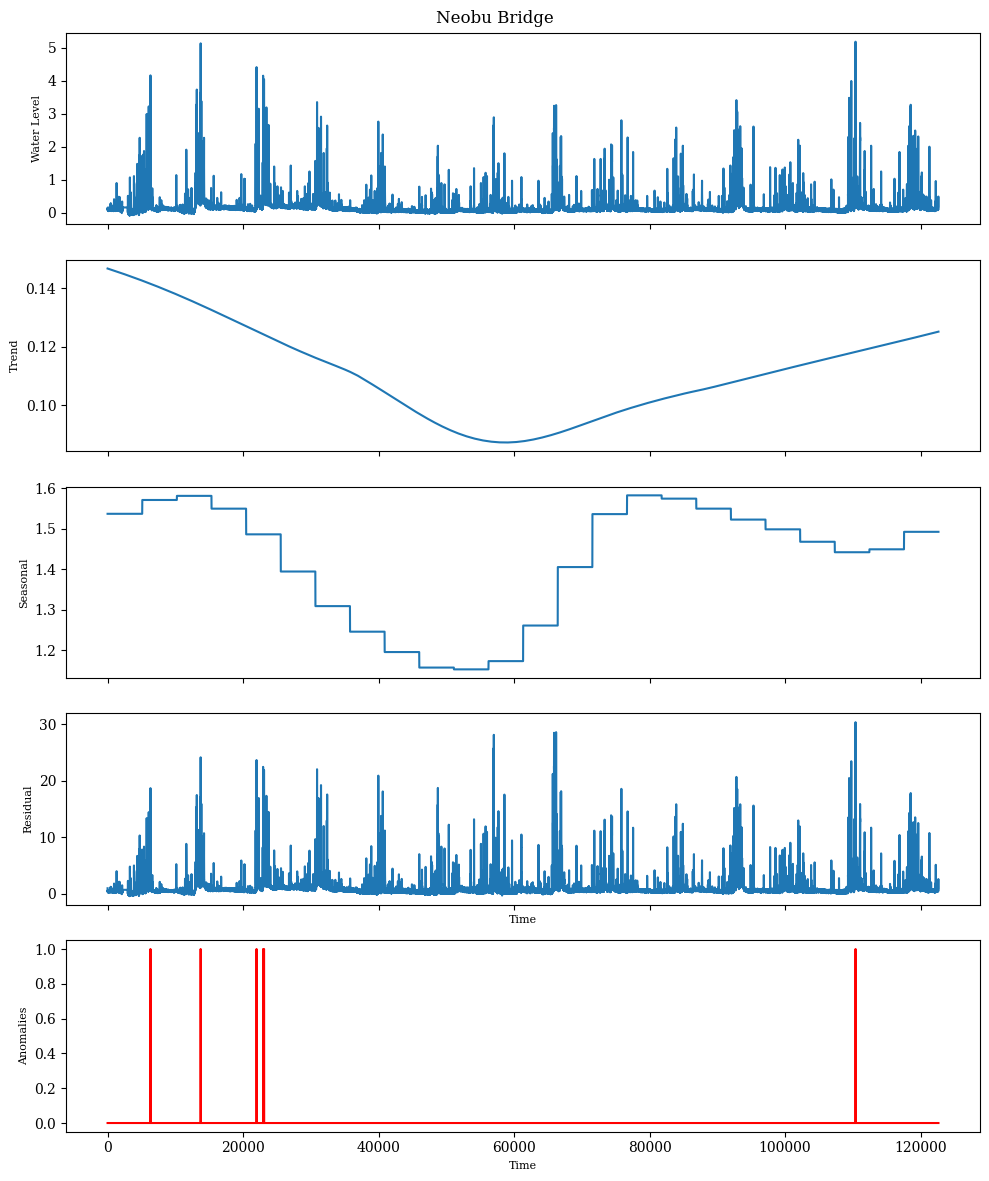

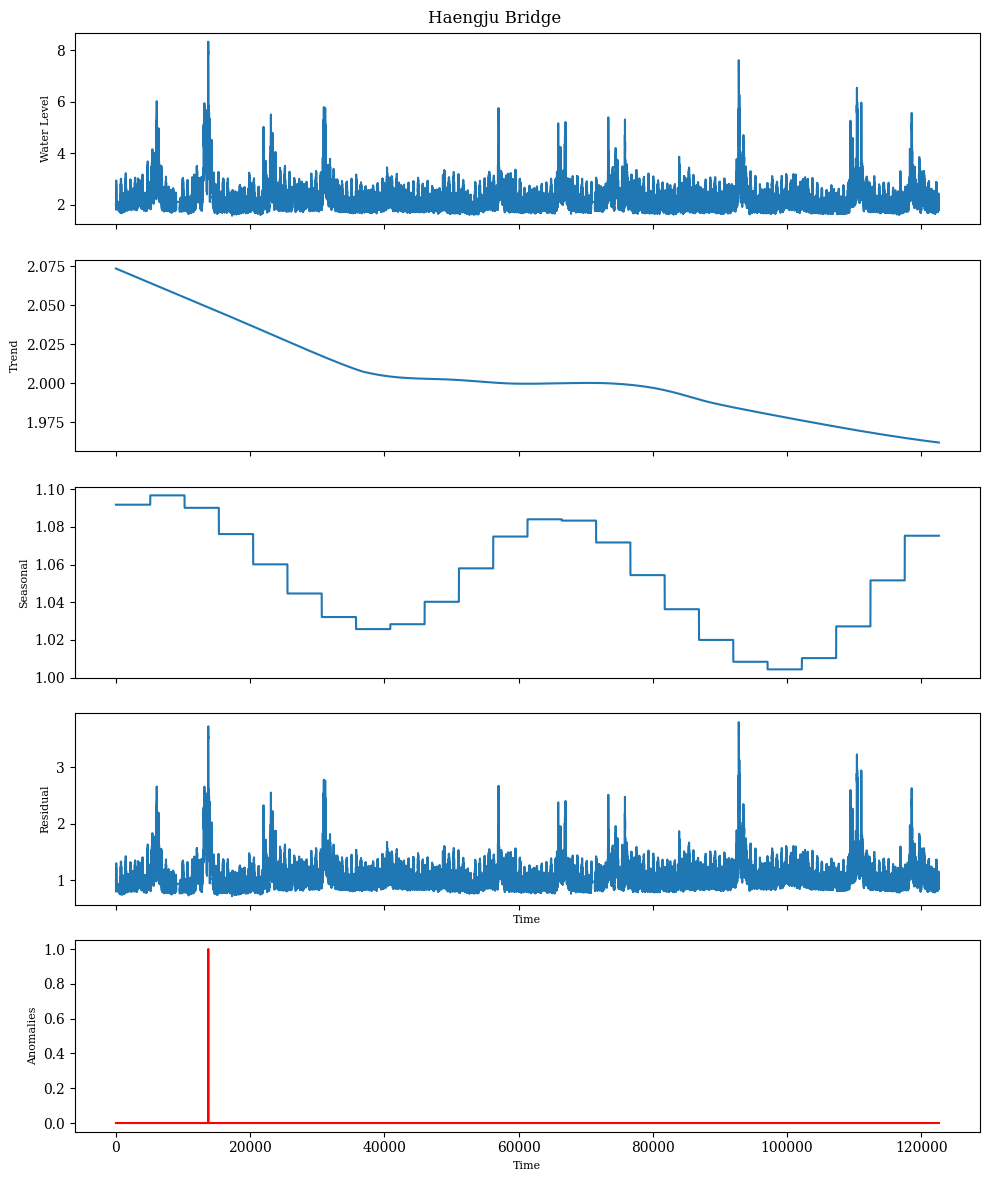

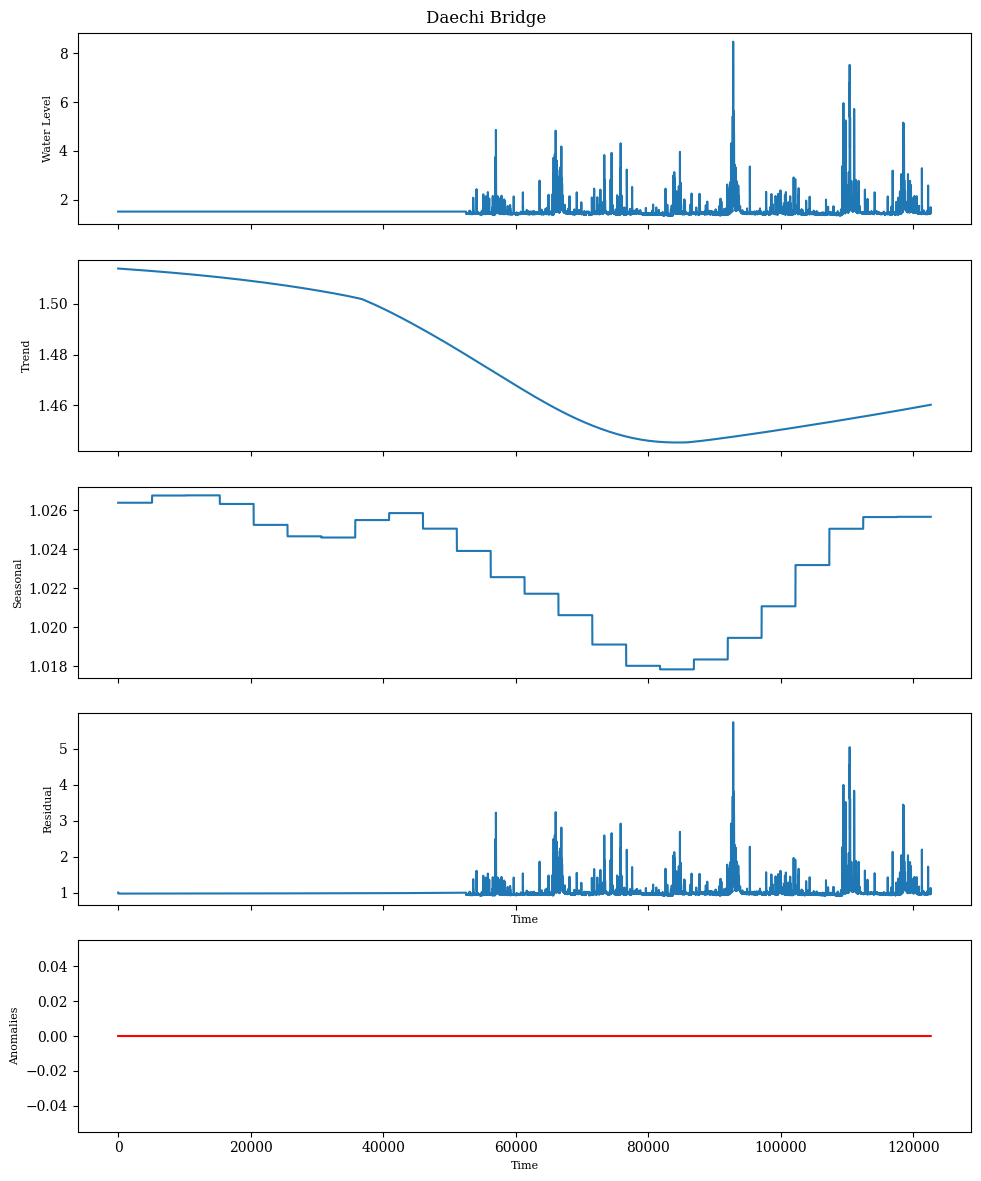

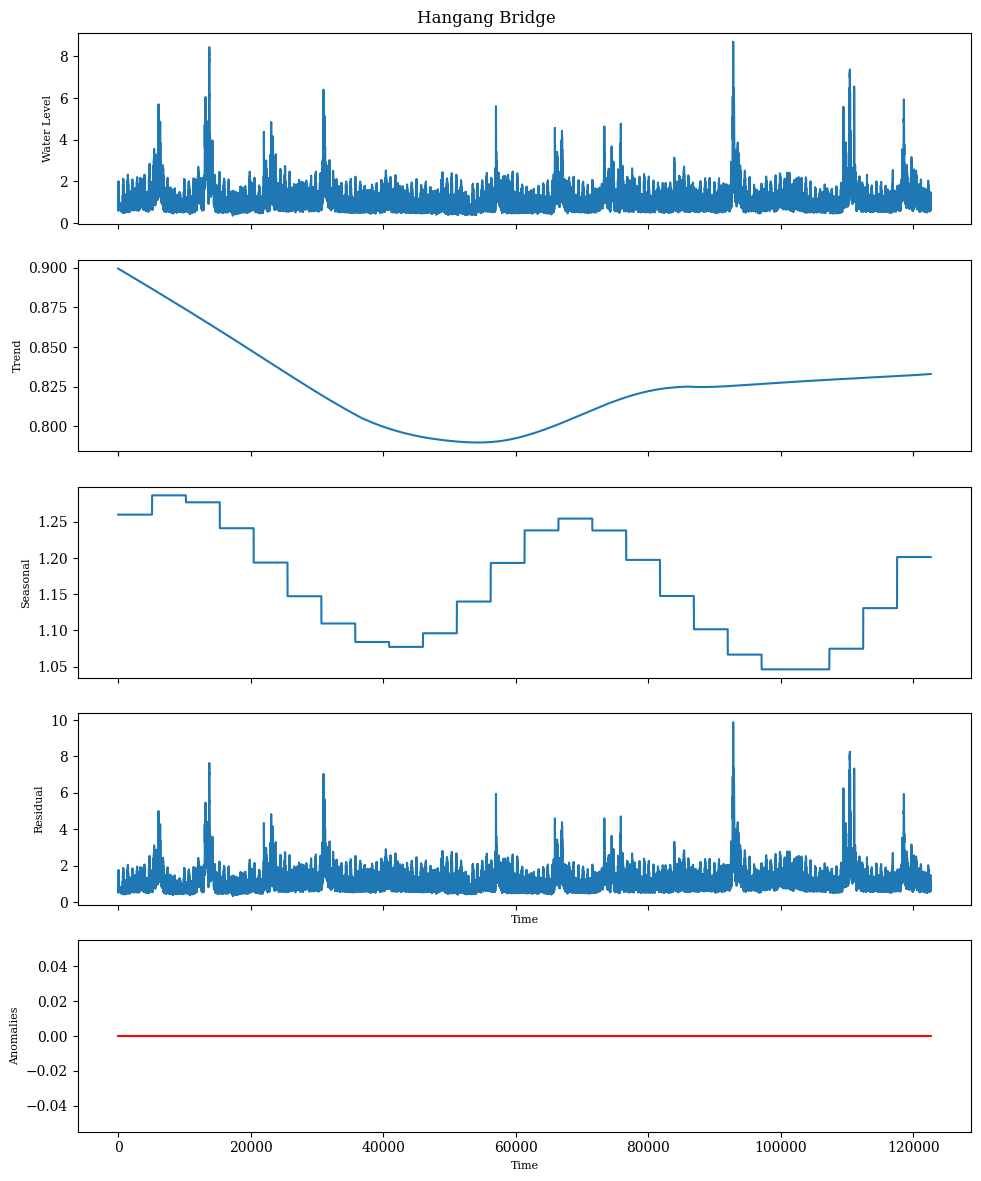

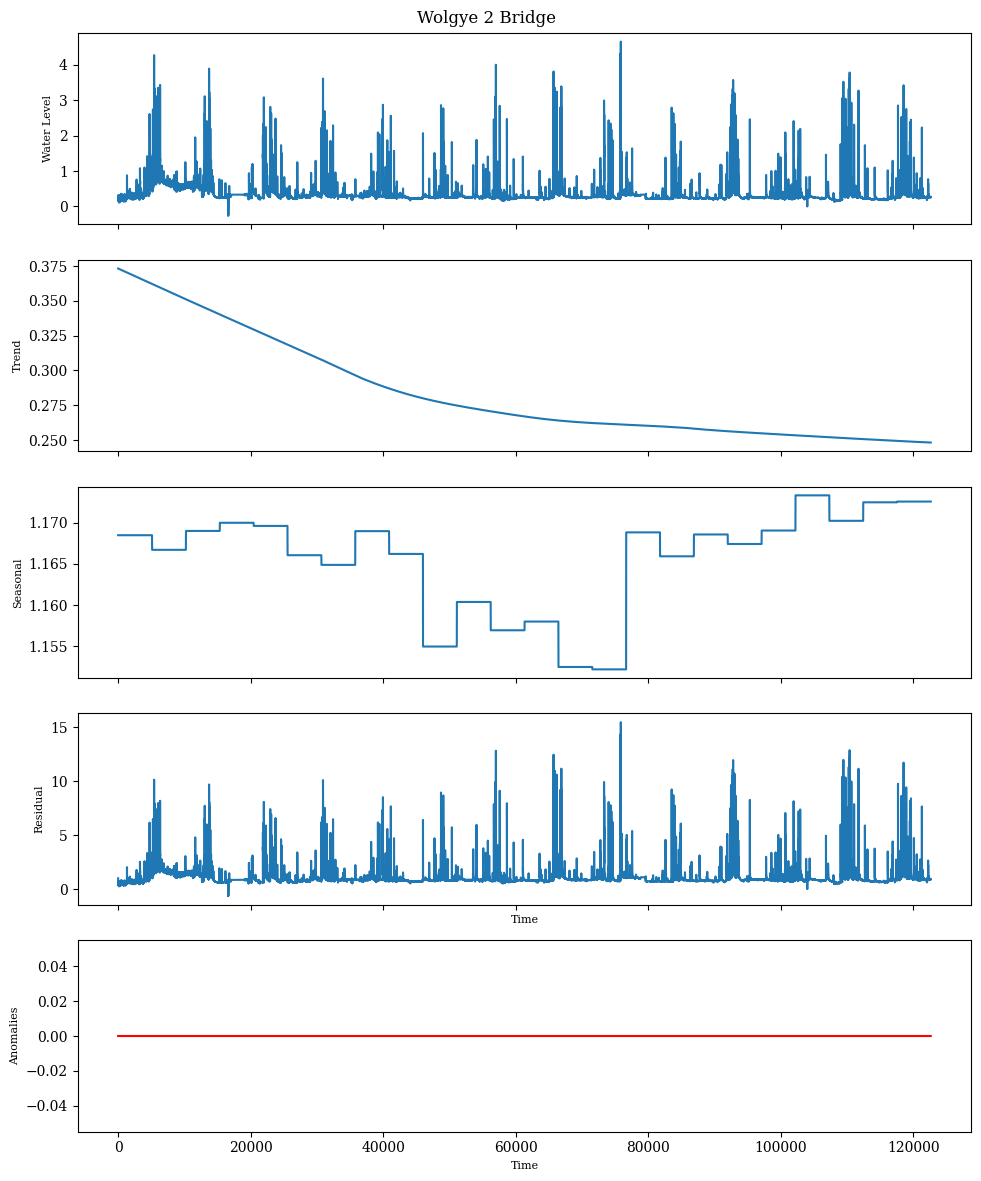

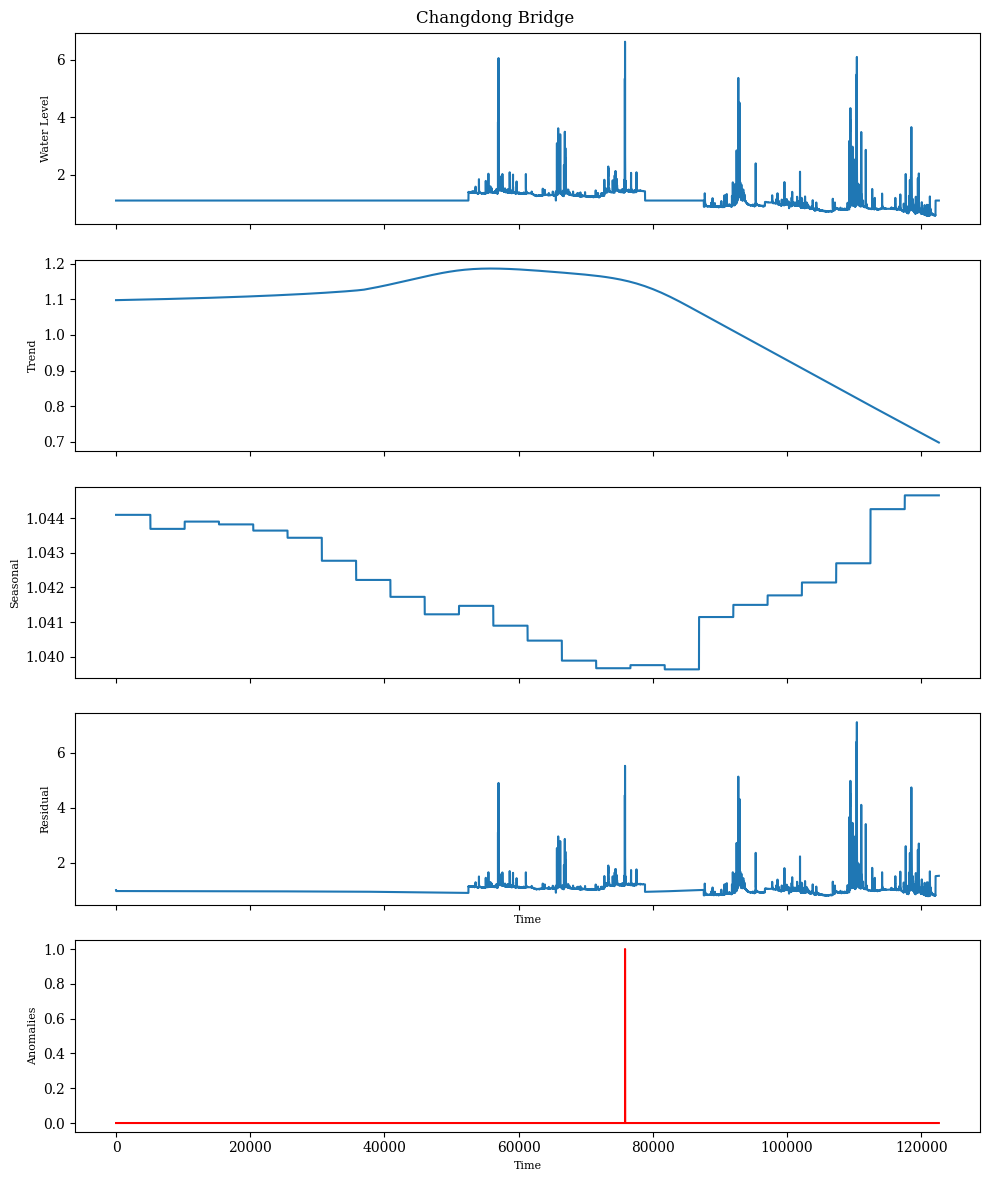

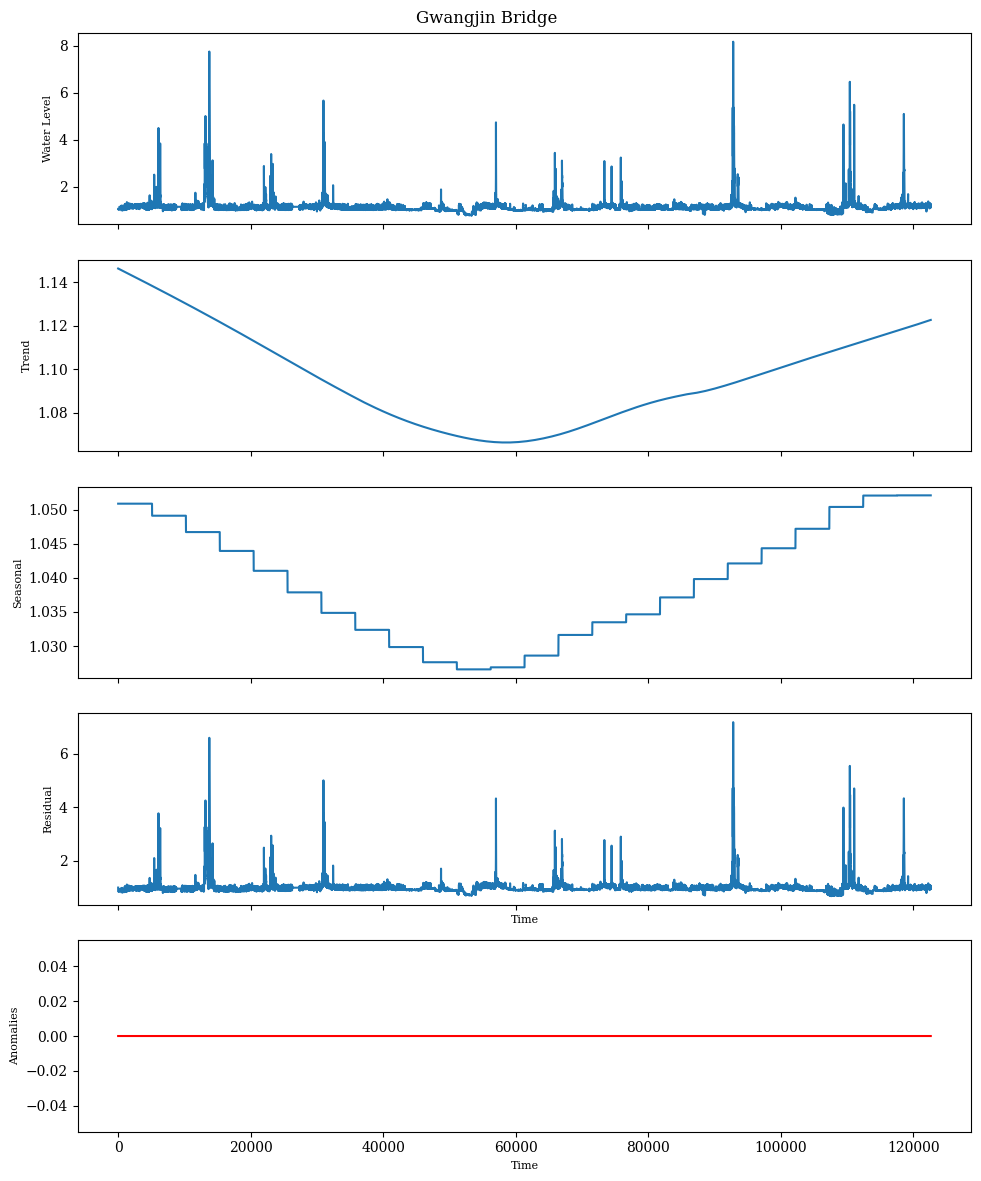

fw    wl  wlobscd       ymdhm      observatory  \
datetime                                                                  
2010-01-01 00:00:00    6.08  1.78  1018655  2010010100    Daegok Bridge   
2010-01-01 01:00:00    6.08  1.78  1018655  2010010101    Daegok Bridge   
2010-01-01 02:00:00    6.08  1.78  1018655  2010010102    Daegok Bridge   
2010-01-01 03:00:00    6.08  1.78  1018655  2010010103    Daegok Bridge   
2010-01-01 04:00:00    6.08  1.78  1018655  2010010104    Daegok Bridge   
...                     ...   ...      ...         ...              ...   
2023-12-31 19:00:00  128.90  1.13  1018640  2023123119  Gwangjin Bridge   
2023-12-31 20:00:00  124.87  1.13  1018640  2023123120  Gwangjin Bridge   
2023-12-31 21:00:00  124.87  1.13  1018640  2023123121  Gwangjin Bridge   
2023-12-31 22:00:00  128.90  1.13  1018640  2023123122  Gwangjin Bridge   
2023-12-31 23:00:00  124.87  1.13  1018640  2023123123  Gwangjin Bridge   

                     interest  attention  caution  serious   latitude  ...  \
datetime                                                               ...   
2010-01-01 00:00:00       3.8        5.5      7.0      8.5  37.468742  ...   
2010-01-01 01:00:00       3.8        5.5      7.0      8.5  37.468742  ...   
2010-01-01 02:00:00       3.8        5.5      7.0      8.5  37.468742  ...   
2010-01-01 03:00:00       3.8        5.5      7.0      8.5  37.468742  ...   
2010-01-01 04:00:00       3.8        5.5      7.0      8.5  37.468742  ...   
...                       ...        ...      ...      ...        ...  ...   
2023-12-31 19:00:00       3.0        8.0     10.5     13.6  37.542950  ...   
2023-12-31 20:00:00       3.0        8.0     10.5     13.6  37.542950  ...   
2023-12-31 21:00:00       3.0        8.0     10.5     13.6  37.542950  ...   
2023-12-31 22:00:00       3.0        8.0     10.5     13.6  37.542950  ...   
2023-12-31 23:00:00       3.0        8.0     10.5     13.6  37.542950  ...   

                     year month  day  hour   rf  warning level     trend  \
datetime                                                                   
2010-01-01 00:00:00  2010     1    1     0  0.0         normal  1.811253   
2010-01-01 01:00:00  2010     1    1     1  0.0         normal  1.811253   
2010-01-01 02:00:00  2010     1    1     2  0.0         normal  1.811253   
2010-01-01 03:00:00  2010     1    1     3  0.0         normal  1.811254   
2010-01-01 04:00:00  2010     1    1     4  0.0         normal  1.811254   
...                   ...   ...  ...   ...  ...            ...       ...   
2023-12-31 19:00:00  2023    12   31    19  4.7         normal  1.122638   
2023-12-31 20:00:00  2023    12   31    20  4.7         normal  1.122639   
2023-12-31 21:00:00  2023    12   31    21  4.7         normal  1.122640   
2023-12-31 22:00:00  2023    12   31    22  4.7         normal  1.122641   
2023-12-31 23:00:00  2023    12   31    23  4.7         normal  1.122642   

                     seasonal  anomalies  residual  
datetime                                            
2010-01-01 00:00:00  1.030851      False  1.000000  
2010-01-01 01:00:00  1.030851      False  0.953334  
2010-01-01 02:00:00  1.030851      False  0.953334  
2010-01-01 03:00:00  1.030851      False  0.953334  
2010-01-01 04:00:00  1.030851      False  0.953334  
...                       ...        ...       ...  
2023-12-31 19:00:00  1.052078      False  0.956733  
2023-12-31 20:00:00  1.052078      False  0.956732  
2023-12-31 21:00:00  1.052078      False  0.956731  
2023-12-31 22:00:00  1.052078      False  0.956731  
2023-12-31 23:00:00  1.052078      False  0.956730  

[1471716 rows x 22 columns]

In [74]:
df_list = []

for bridge in data['observatory'].unique():
  df_dec, warning_level = get_observatory(data, bridge)
  trend, seasonal, anomalies, resid = AA_decompose(df_dec, period=24, warning_level = warning_level['caution'].iloc[0])
  df_dec['trend'] = trend
  df_dec['seasonal'] = seasonal
  df_dec['anomalies'] = anomalies
  df_dec['residual'] = resid
  df_list.append(df_dec)
decompose_by_caution = pd.concat(df_list)
decompose_by_caution

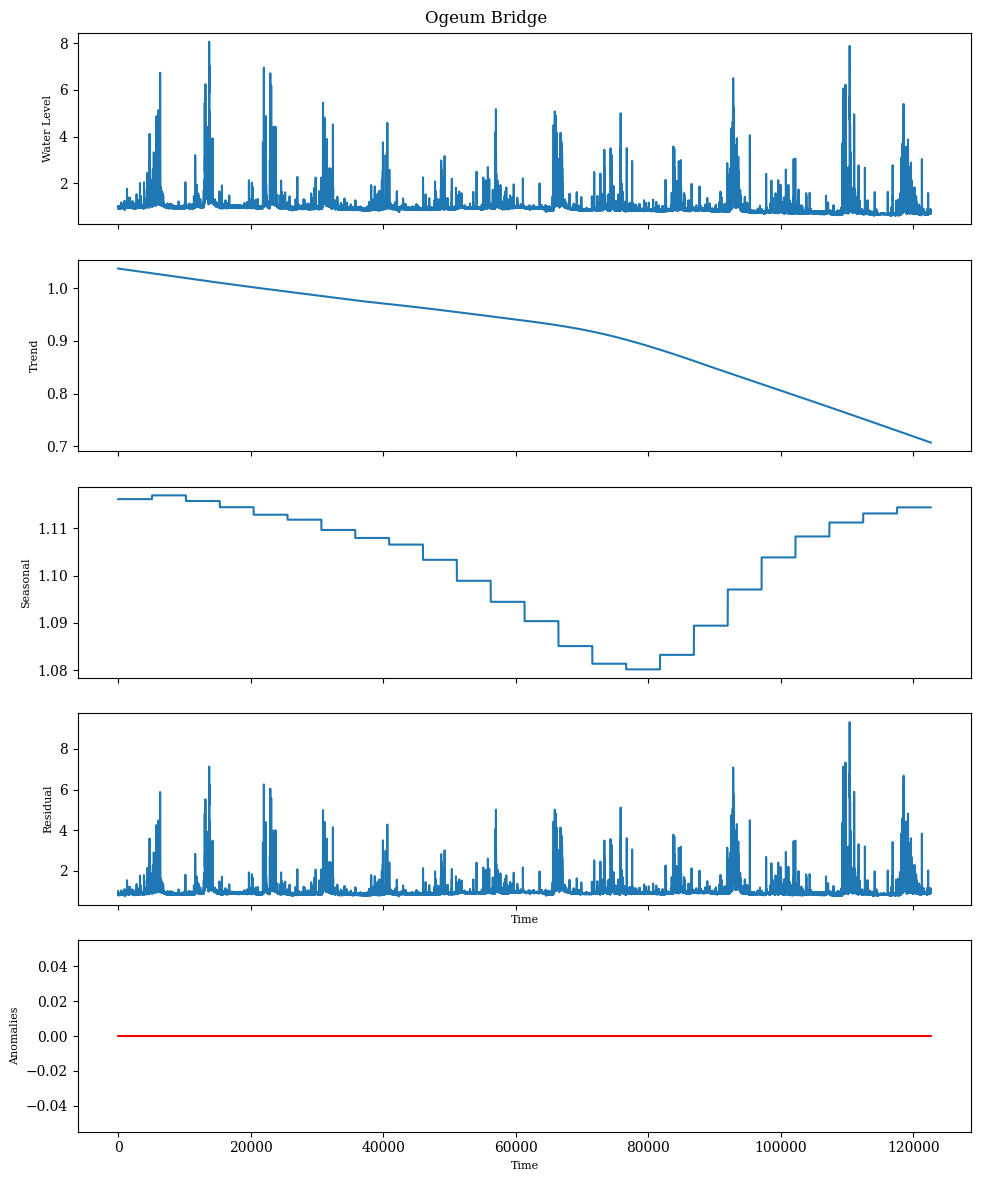

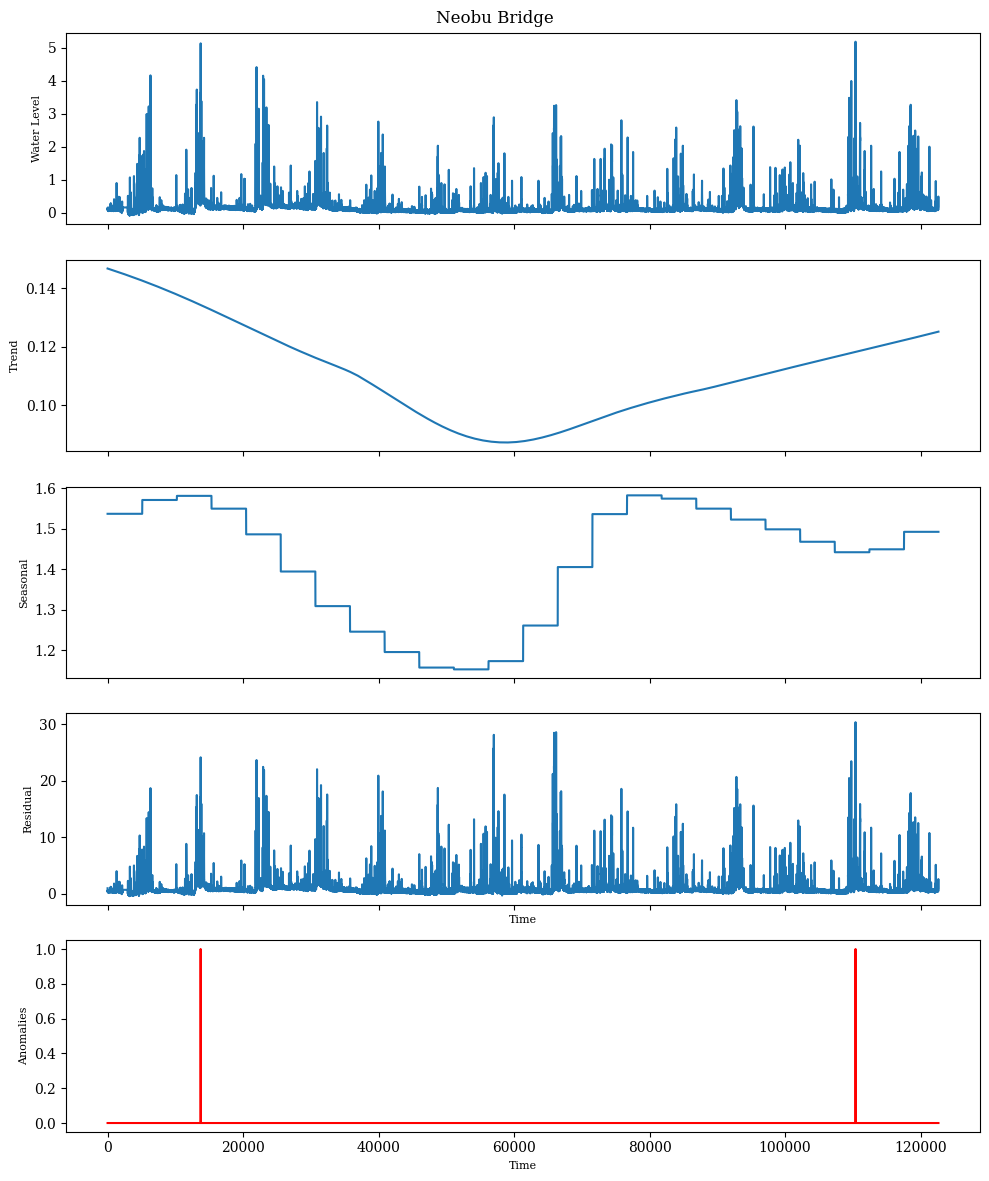

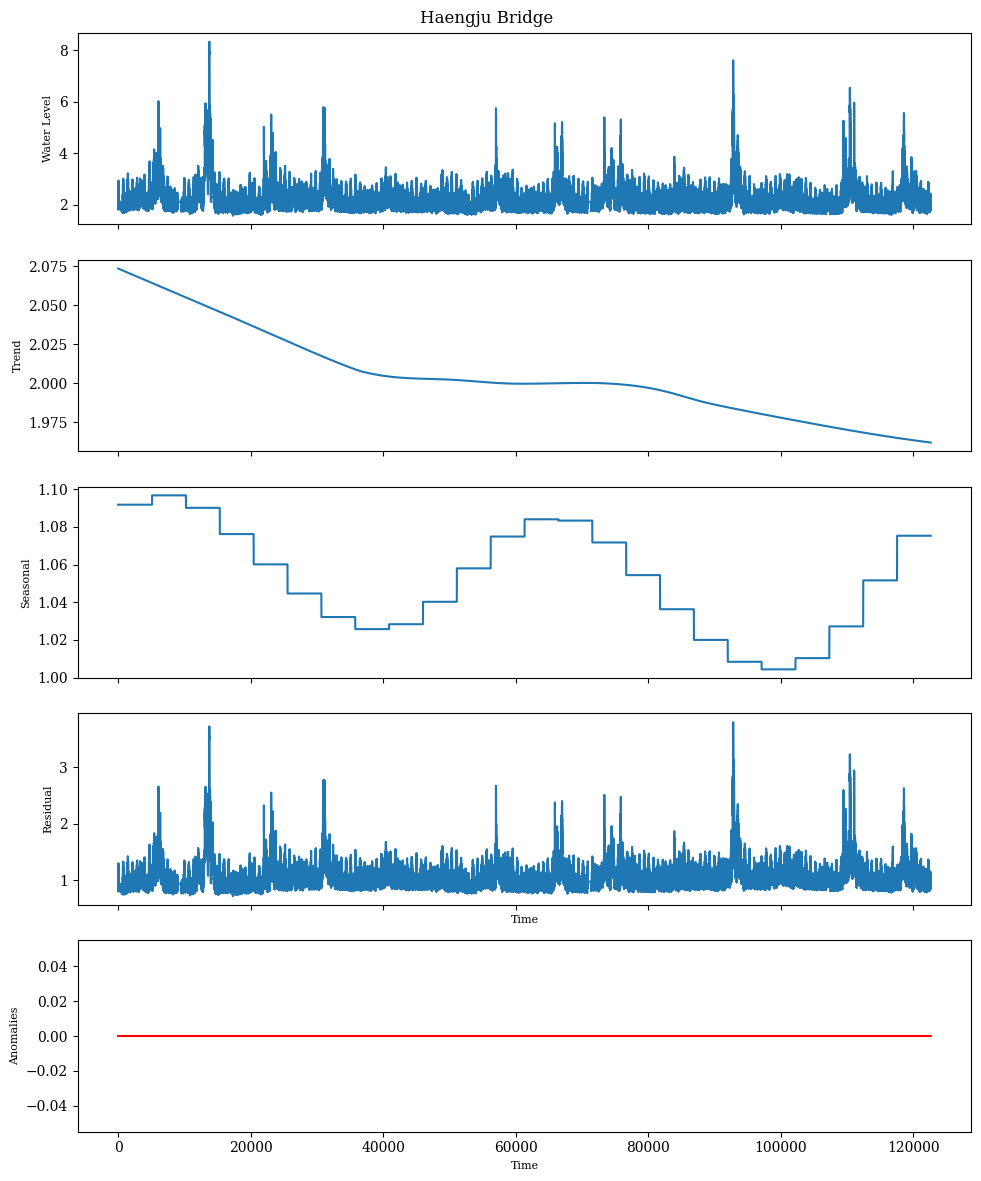

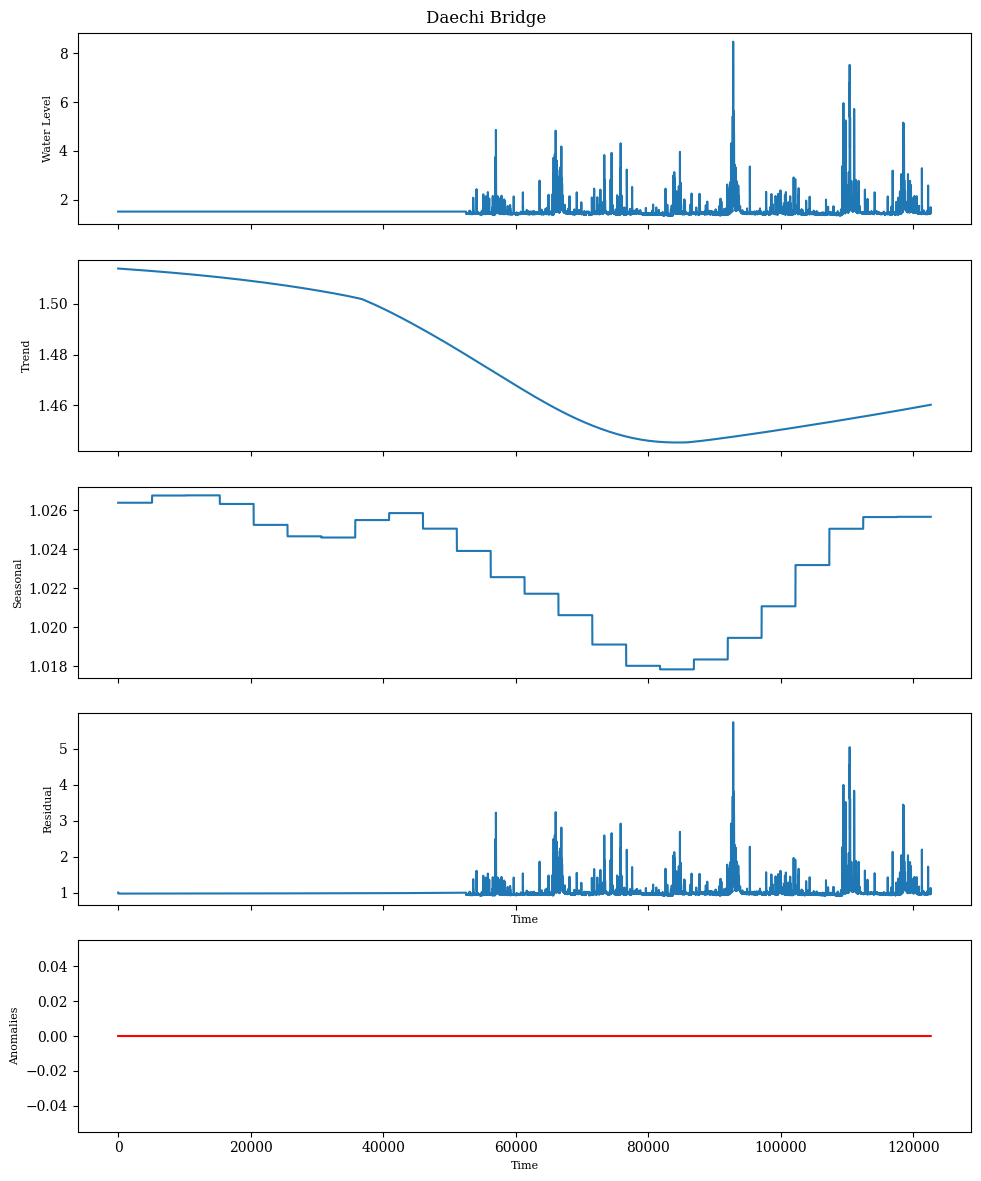

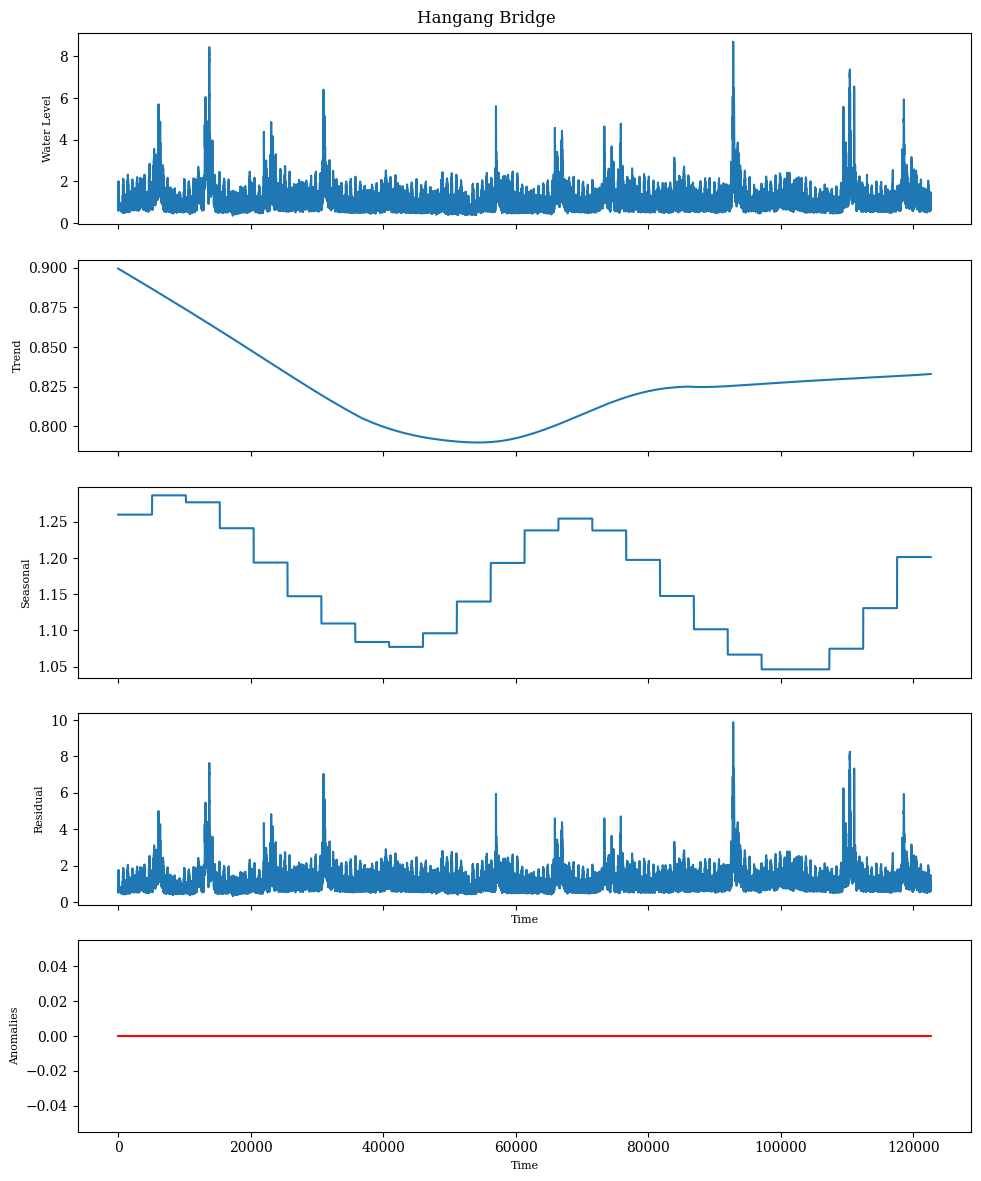

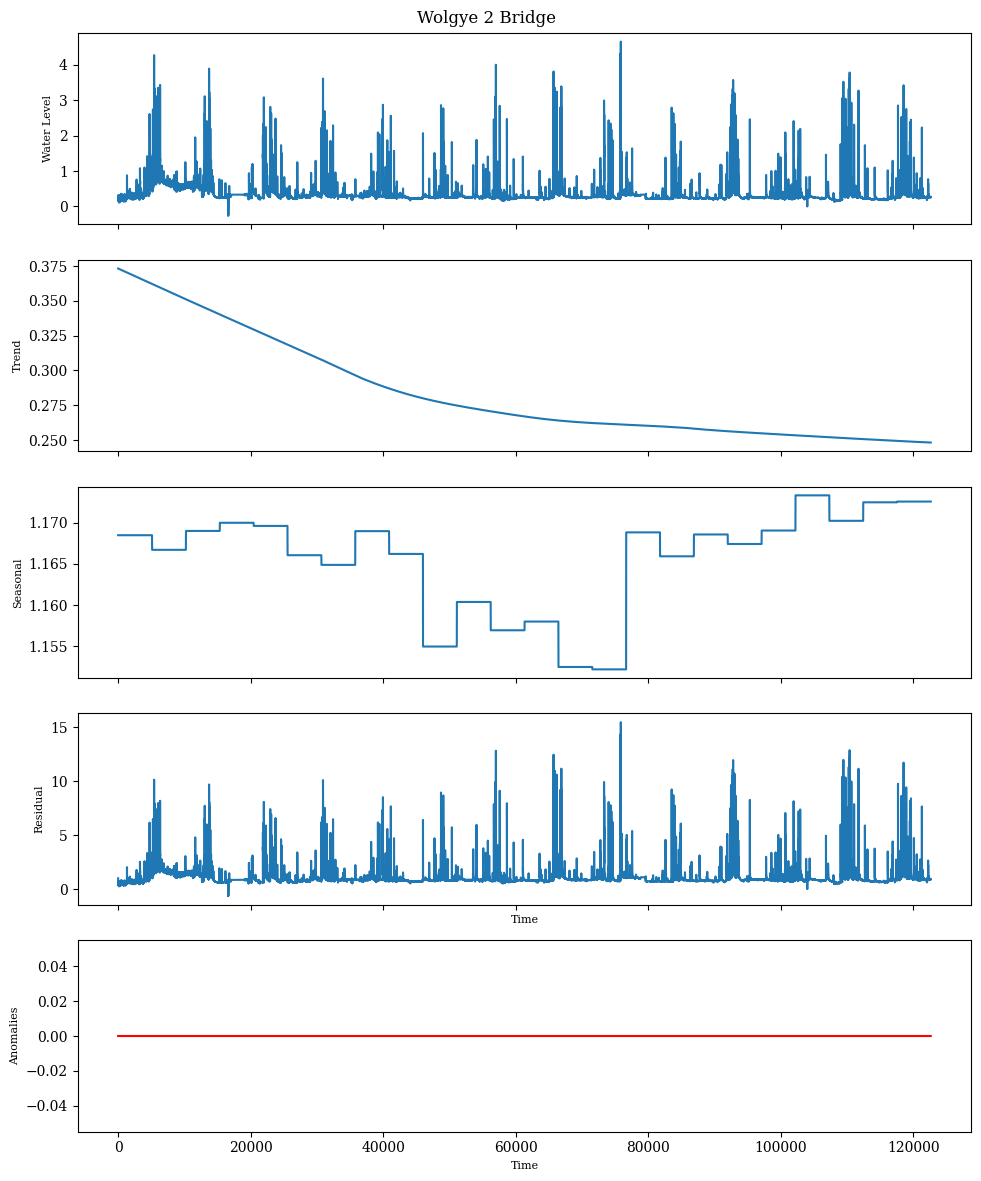

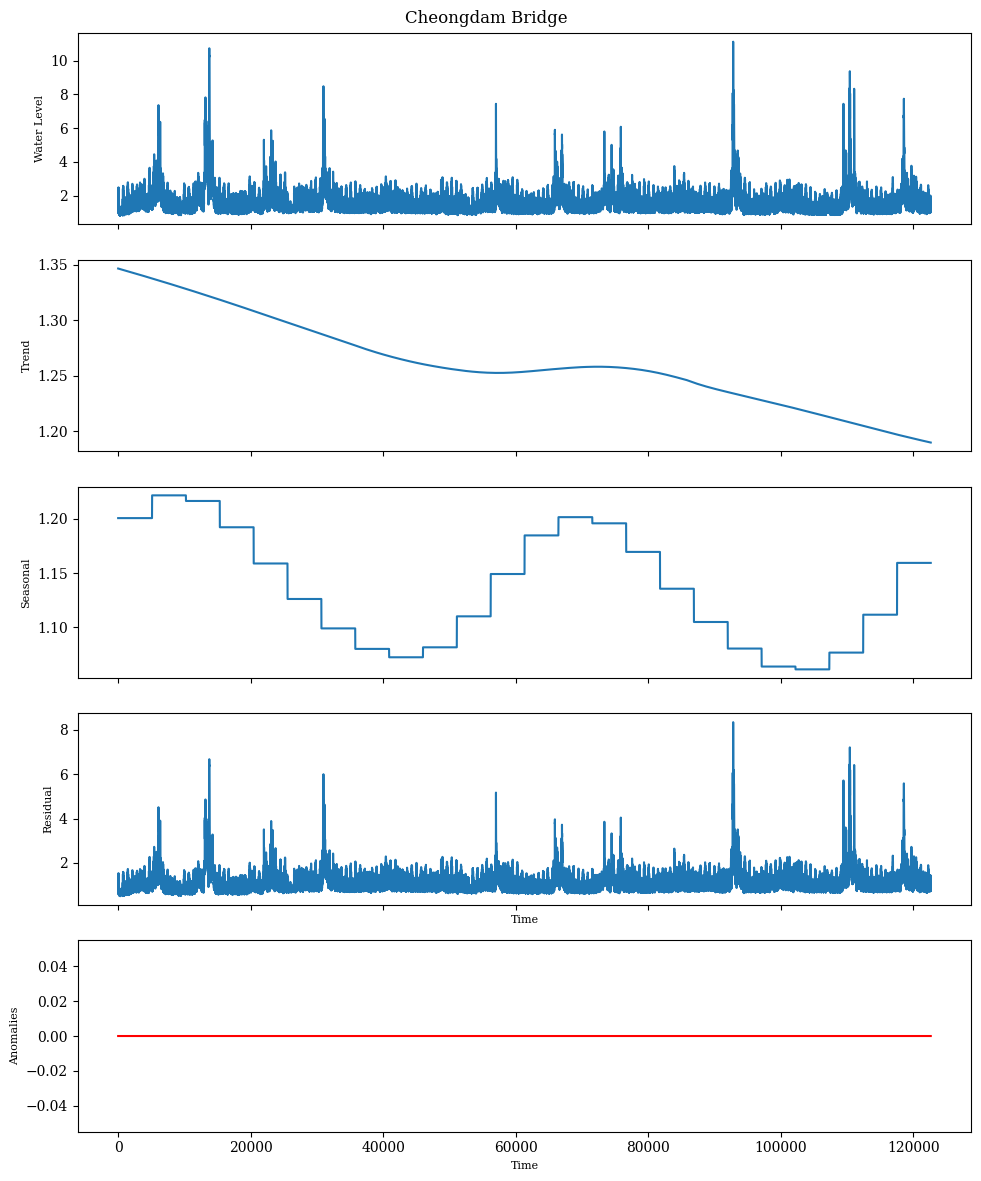

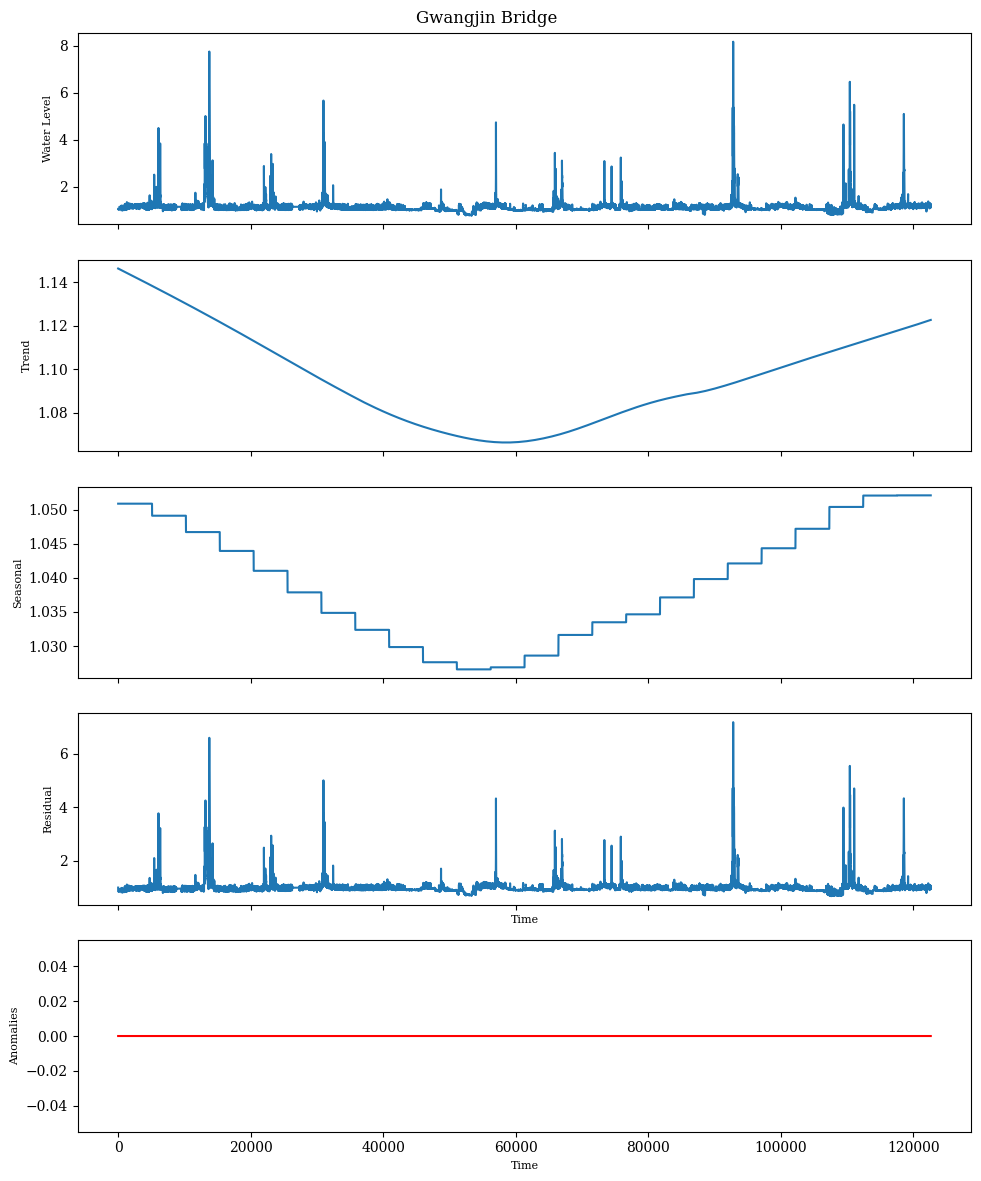

fw    wl  wlobscd       ymdhm      observatory  \
datetime                                                                  
2010-01-01 00:00:00    6.08  1.78  1018655  2010010100    Daegok Bridge   
2010-01-01 01:00:00    6.08  1.78  1018655  2010010101    Daegok Bridge   
2010-01-01 02:00:00    6.08  1.78  1018655  2010010102    Daegok Bridge   
2010-01-01 03:00:00    6.08  1.78  1018655  2010010103    Daegok Bridge   
2010-01-01 04:00:00    6.08  1.78  1018655  2010010104    Daegok Bridge   
...                     ...   ...      ...         ...              ...   
2023-12-31 19:00:00  128.90  1.13  1018640  2023123119  Gwangjin Bridge   
2023-12-31 20:00:00  124.87  1.13  1018640  2023123120  Gwangjin Bridge   
2023-12-31 21:00:00  124.87  1.13  1018640  2023123121  Gwangjin Bridge   
2023-12-31 22:00:00  128.90  1.13  1018640  2023123122  Gwangjin Bridge   
2023-12-31 23:00:00  124.87  1.13  1018640  2023123123  Gwangjin Bridge   

                     interest  attention  caution  serious   latitude  ...  \
datetime                                                               ...   
2010-01-01 00:00:00       3.8        5.5      7.0      8.5  37.468742  ...   
2010-01-01 01:00:00       3.8        5.5      7.0      8.5  37.468742  ...   
2010-01-01 02:00:00       3.8        5.5      7.0      8.5  37.468742  ...   
2010-01-01 03:00:00       3.8        5.5      7.0      8.5  37.468742  ...   
2010-01-01 04:00:00       3.8        5.5      7.0      8.5  37.468742  ...   
...                       ...        ...      ...      ...        ...  ...   
2023-12-31 19:00:00       3.0        8.0     10.5     13.6  37.542950  ...   
2023-12-31 20:00:00       3.0        8.0     10.5     13.6  37.542950  ...   
2023-12-31 21:00:00       3.0        8.0     10.5     13.6  37.542950  ...   
2023-12-31 22:00:00       3.0        8.0     10.5     13.6  37.542950  ...   
2023-12-31 23:00:00       3.0        8.0     10.5     13.6  37.542950  ...   

                     year month  day  hour   rf  warning level     trend  \
datetime                                                                   
2010-01-01 00:00:00  2010     1    1     0  0.0         normal  1.811253   
2010-01-01 01:00:00  2010     1    1     1  0.0         normal  1.811253   
2010-01-01 02:00:00  2010     1    1     2  0.0         normal  1.811253   
2010-01-01 03:00:00  2010     1    1     3  0.0         normal  1.811254   
2010-01-01 04:00:00  2010     1    1     4  0.0         normal  1.811254   
...                   ...   ...  ...   ...  ...            ...       ...   
2023-12-31 19:00:00  2023    12   31    19  4.7         normal  1.122638   
2023-12-31 20:00:00  2023    12   31    20  4.7         normal  1.122639   
2023-12-31 21:00:00  2023    12   31    21  4.7         normal  1.122640   
2023-12-31 22:00:00  2023    12   31    22  4.7         normal  1.122641   
2023-12-31 23:00:00  2023    12   31    23  4.7         normal  1.122642   

                     seasonal  anomalies  residual  
datetime                                            
2010-01-01 00:00:00  1.030851      False  1.000000  
2010-01-01 01:00:00  1.030851      False  0.953334  
2010-01-01 02:00:00  1.030851      False  0.953334  
2010-01-01 03:00:00  1.030851      False  0.953334  
2010-01-01 04:00:00  1.030851      False  0.953334  
...                       ...        ...       ...  
2023-12-31 19:00:00  1.052078      False  0.956733  
2023-12-31 20:00:00  1.052078      False  0.956732  
2023-12-31 21:00:00  1.052078      False  0.956731  
2023-12-31 22:00:00  1.052078      False  0.956731  
2023-12-31 23:00:00  1.052078      False  0.956730  

[1471716 rows x 22 columns]

In [75]:
df_list = []

for bridge in data['observatory'].unique():
  df_dec, warning_level = get_observatory(data, bridge)
  trend, seasonal, anomalies, resid = AA_decompose(df_dec, period=24, warning_level = warning_level['serious'].iloc[0])
  df_dec['trend'] = trend
  df_dec['seasonal'] = seasonal
  df_dec['anomalies'] = anomalies
  df_dec['residual'] = resid
  df_list.append(df_dec)
decompose_by_serious = pd.concat(df_list)
decompose_by_serious

In [76]:
decompose_by_interest.to_csv('decompose_by_interest.csv')
decompose_by_attention.to_csv('decompose_by_attention.csv')
decompose_by_caution.to_csv('decompose_by_caution.csv')
decompose_by_serious.to_csv('decompose_by_serious.csv')